In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import os
verbose_state = True

/home/jesse/.conda/envs/wifi/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def print_c(print_content, verbose = verbose_state):
    
    if verbose == True:
        print(print_content)

In [3]:
print_c("Read pickle data")

f = open('./Data/all_data.pkl', 'rb')
_ = pickle.load(f)
_ = pickle.load(f)
process_data = pd.DataFrame(pickle.load(f))

print_c("Finish read pickle data")
print_c("Process data")

Read pickle data
Finish read pickle data
Process data


In [4]:
#select date
mask = (process_data.columns >= '20130102') & (process_data.columns < '20140302')
select_date = process_data.iloc[:,mask]

#drop NA
select_date = select_date.dropna()

for c in select_date.columns:    
    for idx in select_date[c].index:
        select_date[c].loc[idx] = select_date[c].loc[idx].drop(['ID', 'Date','name','trade']).tolist()
        
#make a stck_df to np_array 
stock_1101 = select_date.loc['1101']
stock_1101_np = np.vstack(np.array(stock_1101))

'''
#make multiple stck_df to np_array        
stocks = ['1101','1102']
stock_1101_02 = select_date.loc[stocks]
stock_1101_02_np = np.hstack(np.array(stock_1101_02))
stock_1101_02_np = np.vstack(np.array(stock_1101_02_np))
stock_1101_02_np_r = np.split(stock_1101_02_np, len(stocks))
stock_1101_02_np_r = np.dstack(stock_1101_02_np_r)
'''

"\n#make multiple stck_df to np_array        \nstocks = ['1101','1102']\nstock_1101_02 = select_date.loc[stocks]\nstock_1101_02_np = np.hstack(np.array(stock_1101_02))\nstock_1101_02_np = np.vstack(np.array(stock_1101_02_np))\nstock_1101_02_np_r = np.split(stock_1101_02_np, len(stocks))\nstock_1101_02_np_r = np.dstack(stock_1101_02_np_r)\n"

In [5]:
#Check process is correct
#print_c("single stock == multiple_stock: {}".format(np.equal(stock_1101_np, stock_1101_02_np_r[:,:,0]).all()))

In [6]:
#Prepare for rnn
print_c("Start build RNN model")

import tensorflow as tf
import random

Start build RNN model


In [7]:
#Single stock

data = stock_1101_np
train_step = 12
test_step = 5
all_step = train_step + test_step
data_size = 50
n_inputs = data.shape[-1]
n_hidden_units = 10
n_output = 3
batch_size = 16


train_portion = int(0.8*len(data))
train, val = np.split(data, [train_portion])

def gen_train_val_set(data, total_time_step):

    data_set = np.zeros((len(data)-total_time_step, total_time_step, data.shape[-1]))

    for i in range(len(data)-total_time_step):

        tmp = data[i:i+total_time_step,:]
        data_set[i] = tmp
        
    return data_set

total_time_step = train_step + test_step
train_set = gen_train_val_set(train, total_time_step)
test_set = gen_train_val_set(val, total_time_step)




In [8]:
print(np.shape(train_set))
print(np.shape(test_set))

(207, 17, 4)
(40, 17, 4)


In [11]:
reuse = False

def default_init(seed):
    # replica of tf.glorot_uniform_initializer(seed=seed)
    return tf.contrib.layers.variance_scaling_initializer(factor=1.0,
                                               mode="FAN_AVG",
                                               uniform=True,
                                               seed=seed)
    

def encoder(X):  
                                                          
    weights = {  
        # (28, 128)  
        'in': tf.get_variable("Win", [data.shape[-1], n_hidden_units], initializer = tf.zeros_initializer()),
       
    }  

  
    biases = {  
            # (128, )  
            'in': tf.get_variable('b_in', [n_hidden_units, ], initializer = tf.constant_initializer(0.1)),  
        }                                           
    # hidden layer for input to cell  
    ########################################  
  
    # transpose the inputs shape from  
    # X ==> (128 batch * 28 steps, 28 inputs)  
    X = tf.reshape(X, [-1, n_inputs])  
  
    # into hidden  
    # X_in = (batch * time_steps, n_hidden_units)  
    X_in = tf.matmul(X, weights['in']) + biases['in']  
    # X_in ==> (batch, 28 time_steps, n_hidden_units)  
    X_in = tf.reshape(X_in, [-1, train_step, n_hidden_units]) 
    
    cell = tf.contrib.rnn.BasicLSTMCell(n_hidden_units)
    init_state = cell.zero_state(batch_size, dtype=tf.float32) 
    outputs, final_state = tf.nn.dynamic_rnn(cell, X_in, initial_state=init_state, time_major=False,scope='cell')  
    
    return outputs, final_state

def decoder(previous_y, state):
    
    predict_days = 5
    cell = tf.contrib.rnn.BasicLSTMCell(n_hidden_units)
    attention_states = enc
    attention_mechanism = tf.contrib.seq2seq.LuongAttention(n_hidden_units, attention_states)

    decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
        cell,
        attention_mechanism,
        attention_layer_size=n_hidden_units)
    
    def cond_fn(time, prev_output, prev_state, array_targets: tf.TensorArray, array_outputs: tf.TensorArray):
        return time < predict_days
    
    def project_fn(tensor):
        with tf.variable_scope('decoder_output_proj') as scope:
            if reuse: scope.reuse_variables()
            d_layer = tf.layers.dense(tensor, 1, name='decoder_output_proj', kernel_initializer=default_init(0))
        return d_layer

    def loop_fn(time, prev_output, prev_state, array_targets: tf.TensorArray, array_outputs: tf.TensorArray):
        
        next_input = prev_output
        
        with tf.variable_scope('decoder') as scope:
            if reuse: scope.reuse_variables()
            output, state = cell(next_input, prev_state)
            projected_output = project_fn(output)
            #projected_output = output
        
        array_outputs = array_outputs.write(time, output)
        array_targets = array_targets.write(time, projected_output)
        
        return time + 1, projected_output, state, array_targets, array_outputs
    
    loop_init = [tf.constant(0, dtype=tf.int32), #time
                     project_fn(previous_y), 
                     state,
                     tf.TensorArray(dtype=tf.float32, size=predict_days),
                     tf.TensorArray(dtype=tf.float32, size=predict_days) ]
        
    _, _, _, targets_ta, outputs_ta = tf.while_loop(cond_fn, loop_fn, loop_init)
    
    targets = targets_ta.stack()
    # [time, batch_size, 1] -> [time, batch_size]
    targets = tf.squeeze(targets, axis=-1)
    raw_outputs = outputs_ta.stack()
    
    targets = tf.transpose(targets, (1,0))
    raw_outputs = tf.transpose(raw_outputs, (1,0,2))


    return targets, raw_outputs



In [12]:


# tf Graph input  
x = tf.placeholder(tf.float32, [None, train_step, data.shape[-1]]) 

with tf.variable_scope('encoder') as scope:
    if reuse: scope.reuse_variables()
    enc, state  = encoder(x)
with tf.variable_scope('decoder') as scope:
    if reuse: scope.reuse_variables()
    dec, raw_dec = decoder(enc[:,-1], state)
print(state)

LSTMStateTuple(c=<tf.Tensor 'encoder_1/cell/while/Exit_2:0' shape=(16, 10) dtype=float32>, h=<tf.Tensor 'encoder_1/cell/while/Exit_3:0' shape=(16, 10) dtype=float32>)


In [ ]:
x = tf.placeholder(tf.float32, [None, train_step, data.shape[-1]]) 



with tf.variable_scope('encoder') as scope:
    if reuse: scope.reuse_variables()
    enc, state  = encoder(x)
    
num_units = 10
source_sequence_length = 12

decoder_cell = tf.contrib.rnn.BasicLSTMCell(num_units)

target_sequence_length = tf.placeholder(tf.int32, (None,), name='target_sequence_length')
y = tf.placeholder(tf.float32, (None,5,1), name='target_sequence_length')
output_layer = tf.layers.Dense(1,
                         kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))


def project_fn(tensor):
    d_layer = tf.layers.dense(tensor, 1, kernel_initializer=default_init(0))
    #d_layer = tf.reshape(d_layer, (-1,1))
    return d_layer

enc_p = project_fn(enc[:,-1])
print(enc_p)

helper = tf.contrib.seq2seq.TrainingHelper(y, target_sequence_length)

training_decoder = tf.contrib.seq2seq.BasicDecoder(
    cell = decoder_cell,
    helper = helper,
    initial_state = state,
    output_layer = output_layer)

final_outputs, _ , _= tf.contrib.seq2seq.dynamic_decode(training_decoder)


In [ ]:
num_units = 10
source_sequence_length = 12

decoder_cell = tf.contrib.rnn.BasicLSTMCell(num_units)
#attention_states = tf.transpose(enc, [1, 0, 2])
attention_states = enc
attention_mechanism = tf.contrib.seq2seq.LuongAttention(
    num_units, attention_states)

decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
    decoder_cell,
    attention_mechanism,
    attention_layer_size=num_units)



In [ ]:
training_decoder = tf.contrib.seq2seq.BasicDecoder(
    cell = decoder_cell,
    helper = helper,
    initial_state = decoder_cell.zero_state(16, tf.float32).clone(cell_state=state),
    output_layer = tf.layers.Dense(1))

final_outputs, _ , _= tf.contrib.seq2seq.dynamic_decode(training_decoder)

In [14]:

import tensorflow as tf
tvars = tf.trainable_variables()
tf.contrib.seq2seq.AttentionWrapper

tensorflow.contrib.seq2seq.python.ops.attention_wrapper.AttentionWrapper

In [15]:
y = tf.placeholder(tf.float32, [None, test_step])  
loss = tf.losses.mean_squared_error(
    y,
    dec,
    )

with tf.variable_scope('optimizer') as scope:
    if reuse: scope.reuse_variables()
    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

In [18]:
with tf.name_scope('train_summary'):
    tf.summary.scalar('l2loss', loss, collections=['train'])
    merged_summary_train = tf.summary.merge_all('train')     
    
with tf.name_scope('validatin_summary'):
    tf.summary.scalar('l2loss', loss, collections=['validatin'])
    merged_summary_val = tf.summary.merge_all('validatin') 
    
saver = tf.train.Saver()


In [19]:
def get_batch(data_set, train_step,batch_size, cur_index):
    
    #data_set: [None, time_step, features ]
    #batch_idx: index of batch start point
    assert(len(data_set) < cur_index+batch_size, "batch index out of range")
    batch =  data_set[cur_index:cur_index + batch_size, :, :]
    train, label = np.split(batch, [train_step], axis=1)
    label = label[:,:,-1]
    return train, label

<ipython-input-19-0a7802896c6f>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(data_set) < cur_index+batch_size, "batch index out of range")


In [20]:
batch, label = get_batch(train_set, 12,50, 20)
print(np.shape(batch), np.shape(label))
print(train_set)

(50, 12, 4) (50, 5)
[[[30.41 30.53 30.18 30.45]
  [30.84 30.84 30.25 30.33]
  [30.76 30.8  30.14 30.45]
  ...
  [30.33 30.53 30.02 30.45]
  [30.29 30.49 30.22 30.41]
  [30.29 30.57 30.06 30.45]]

 [[30.84 30.84 30.25 30.33]
  [30.76 30.8  30.14 30.45]
  [30.53 30.53 30.18 30.37]
  ...
  [30.29 30.49 30.22 30.41]
  [30.29 30.57 30.06 30.45]
  [30.37 30.64 30.18 30.53]]

 [[30.76 30.8  30.14 30.45]
  [30.53 30.53 30.18 30.37]
  [30.37 30.53 29.82 30.06]
  ...
  [30.29 30.57 30.06 30.45]
  [30.37 30.64 30.18 30.53]
  [30.53 30.88 30.37 30.64]]

 ...

 [[34.74 34.74 33.84 34.12]
  [33.71 34.08 33.67 33.67]
  [33.67 33.96 33.26 33.51]
  ...
  [34.66 35.27 34.53 34.99]
  [35.32 36.14 35.23 35.85]
  [35.56 37.45 35.56 35.81]]

 [[33.71 34.08 33.67 33.67]
  [33.67 33.96 33.26 33.51]
  [33.51 33.71 33.22 33.71]
  ...
  [35.32 36.14 35.23 35.85]
  [35.56 37.45 35.56 35.81]
  [36.51 37.45 36.3  36.96]]

 [[33.67 33.96 33.26 33.51]
  [33.51 33.71 33.22 33.71]
  [33.06 33.71 33.06 33.71]
  ...
  [3

In [22]:
def save_ckpt(saver:tf.train.Saver(), sess, checkpoint_dir, ckpt_name, step):
    
    print(" [*] Saving checkpoints...step: [{}]".format(step))
    if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

    saver.save(sess, 
               os.path.join(checkpoint_dir, ckpt_name),
               global_step=step)
    
from tqdm import tqdm
checkpoint_dir = './model/forfun'
ckpt_name = 'toy'

pbar = tqdm(total=100)
init = tf.global_variables_initializer()  
epoch = 0
Nepoch = 10000
pbar = tqdm(total=Nepoch)

with tf.Session() as sess:  
    
    sess.run(init)
    summary_writer = tf.summary.FileWriter('./data/log', sess.graph)
    
    while epoch < Nepoch:
        
        epoch += 1
        pbar.update(1)
        
        np.random.shuffle(train_set)
        Nbatch = len(train_set)//batch_size
        
        for i in range(Nbatch):         
            batch_index = i*batch_size
            train_data, label = get_batch(train_set, train_step, batch_size, batch_index)
            _ =  sess.run(train_op, feed_dict={x:train_data, y:label})
       
        if epoch%11 == 0:
            l2loss, train_sum =  sess.run([loss, merged_summary_train], feed_dict={x:train_data, y:label})
            #Save tensorboard
            summary_writer.add_summary(train_sum, epoch)
            #Save ckpt
            save_ckpt(saver, sess, checkpoint_dir, ckpt_name, epoch)
            pbar.set_description('train l2loss: {}'.format(l2loss))       
            
            
            
        if epoch%20 == 0:
            val_data, val_label = get_batch(test_set, train_step, batch_size, 0)
            l2loss, val_sum =  sess.run([loss, merged_summary_val], feed_dict={x:val_data, y:val_label})
            #Save tensorboard
            summary_writer.add_summary(val_sum, epoch)
            pbar.set_description('val l2loss: {}'.format(l2loss))
    
    
    out, state= sess.run([dec, raw_dec], feed_dict={x:val_data})
    '''
    for i in range(50):
        l2loss,_ =  sess.run([loss, train_op], feed_dict={x:train, y:test})
        print('l2loss: {}'.format(l2loss))
    
    print_c('============================')
    print_c('{},{}'.format(np.shape(out), np.shape(state)))
   '''


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 11/10000 [00:06<1:42:10,  1.63it/s]


 [*] Saving checkpoints...step: [11]


train l2loss: 854.1956787109375:   0%|          | 23/10000 [00:15<2:03:35,  1.35it/s]

 [*] Saving checkpoints...step: [22]


train l2loss: 854.1956787109375:   0%|          | 33/10000 [00:21<1:41:01,  1.64it/s]

 [*] Saving checkpoints...step: [33]


train l2loss: 753.919921875:   0%|          | 45/10000 [00:29<1:54:33,  1.45it/s]    

 [*] Saving checkpoints...step: [44]


train l2loss: 750.9470825195312:   1%|          | 56/10000 [00:36<1:57:38,  1.41it/s]

 [*] Saving checkpoints...step: [55]


val l2loss: 1079.2962646484375:   1%|          | 66/10000 [00:42<1:41:11,  1.64it/s] 

 [*] Saving checkpoints...step: [66]


train l2loss: 726.3900146484375:   1%|          | 78/10000 [00:50<1:58:30,  1.40it/s]

 [*] Saving checkpoints...step: [77]


train l2loss: 648.2365112304688:   1%|          | 89/10000 [00:57<1:49:10,  1.51it/s]

 [*] Saving checkpoints...step: [88]


train l2loss: 642.758056640625:   1%|          | 100/10000 [01:04<1:57:08,  1.41it/s]

 [*] Saving checkpoints...step: [99]


train l2loss: 644.6536254882812:   1%|          | 111/10000 [01:11<1:47:53,  1.53it/s]

 [*] Saving checkpoints...step: [110]


train l2loss: 687.59814453125:   1%|          | 122/10000 [01:18<1:50:18,  1.49it/s]  

 [*] Saving checkpoints...step: [121]


train l2loss: 663.2319946289062:   1%|▏         | 133/10000 [01:25<1:48:25,  1.52it/s]

 [*] Saving checkpoints...step: [132]


val l2loss: 940.3093872070312:   1%|▏         | 143/10000 [01:31<1:40:08,  1.64it/s]  

 [*] Saving checkpoints...step: [143]


train l2loss: 635.6019287109375:   2%|▏         | 155/10000 [01:39<1:44:30,  1.57it/s]

 [*] Saving checkpoints...step: [154]


train l2loss: 602.2413330078125:   2%|▏         | 166/10000 [01:46<1:50:36,  1.48it/s]

 [*] Saving checkpoints...step: [165]


train l2loss: 674.228759765625:   2%|▏         | 177/10000 [01:53<1:41:22,  1.61it/s] 

 [*] Saving checkpoints...step: [176]


train l2loss: 613.0419921875:   2%|▏         | 188/10000 [02:00<1:48:08,  1.51it/s]  

 [*] Saving checkpoints...step: [187]


train l2loss: 568.8264770507812:   2%|▏         | 199/10000 [02:07<1:42:56,  1.59it/s]

 [*] Saving checkpoints...step: [198]


train l2loss: 614.63427734375:   2%|▏         | 210/10000 [02:14<1:43:37,  1.57it/s]  

 [*] Saving checkpoints...step: [209]


train l2loss: 564.3809814453125:   2%|▏         | 220/10000 [02:22<1:51:06,  1.47it/s]

 [*] Saving checkpoints...step: [220]


train l2loss: 554.1856689453125:   2%|▏         | 232/10000 [02:29<1:50:21,  1.48it/s]

 [*] Saving checkpoints...step: [231]


val l2loss: 844.5931396484375:   2%|▏         | 242/10000 [02:35<1:52:21,  1.45it/s]  

 [*] Saving checkpoints...step: [242]


train l2loss: 551.6182861328125:   3%|▎         | 254/10000 [02:43<1:43:52,  1.56it/s]

 [*] Saving checkpoints...step: [253]


train l2loss: 523.2711791992188:   3%|▎         | 265/10000 [02:50<1:47:30,  1.51it/s]

 [*] Saving checkpoints...step: [264]


train l2loss: 545.8675537109375:   3%|▎         | 276/10000 [02:57<1:45:34,  1.54it/s]

 [*] Saving checkpoints...step: [275]


val l2loss: 812.5599365234375:   3%|▎         | 286/10000 [03:04<1:49:14,  1.48it/s]  

 [*] Saving checkpoints...step: [286]


train l2loss: 511.46051025390625:   3%|▎         | 298/10000 [03:10<54:28,  2.97it/s] 

 [*] Saving checkpoints...step: [297]


train l2loss: 484.0277404785156:   3%|▎         | 309/10000 [03:16<1:54:11,  1.41it/s]

 [*] Saving checkpoints...step: [308]


train l2loss: 484.0277404785156:   3%|▎         | 319/10000 [03:22<1:41:33,  1.59it/s]

 [*] Saving checkpoints...step: [319]


train l2loss: 491.6997985839844:   3%|▎         | 331/10000 [03:30<1:51:50,  1.44it/s]

 [*] Saving checkpoints...step: [330]


train l2loss: 471.5970764160156:   3%|▎         | 342/10000 [03:37<1:42:52,  1.56it/s]

 [*] Saving checkpoints...step: [341]


train l2loss: 464.2086486816406:   4%|▎         | 353/10000 [03:44<1:44:14,  1.54it/s]

 [*] Saving checkpoints...step: [352]


train l2loss: 484.0352478027344:   4%|▎         | 364/10000 [03:52<1:39:40,  1.61it/s]

 [*] Saving checkpoints...step: [363]


train l2loss: 484.0352478027344:   4%|▎         | 374/10000 [03:58<1:48:39,  1.48it/s]

 [*] Saving checkpoints...step: [374]


val l2loss: 738.9786376953125:   4%|▍         | 385/10000 [04:05<1:46:41,  1.50it/s]  

 [*] Saving checkpoints...step: [385]


train l2loss: 502.13238525390625:   4%|▍         | 397/10000 [04:13<1:39:54,  1.60it/s]

 [*] Saving checkpoints...step: [396]


train l2loss: 480.8898010253906:   4%|▍         | 408/10000 [04:20<1:40:30,  1.59it/s] 

 [*] Saving checkpoints...step: [407]


train l2loss: 480.8898010253906:   4%|▍         | 418/10000 [04:27<1:51:13,  1.44it/s]

 [*] Saving checkpoints...step: [418]


val l2loss: 711.2737426757812:   4%|▍         | 429/10000 [04:34<1:50:39,  1.44it/s]  

 [*] Saving checkpoints...step: [429]


val l2loss: 697.7186279296875:   4%|▍         | 441/10000 [04:42<1:46:15,  1.50it/s]   

 [*] Saving checkpoints...step: [440]


val l2loss: 697.7186279296875:   5%|▍         | 451/10000 [04:48<1:48:11,  1.47it/s]

 [*] Saving checkpoints...step: [451]


val l2loss: 684.339111328125:   5%|▍         | 462/10000 [04:55<1:48:25,  1.47it/s]   

 [*] Saving checkpoints...step: [462]


train l2loss: 434.37811279296875:   5%|▍         | 474/10000 [05:03<1:39:44,  1.59it/s]

 [*] Saving checkpoints...step: [473]


val l2loss: 671.1166381835938:   5%|▍         | 484/10000 [05:10<1:42:42,  1.54it/s]   

 [*] Saving checkpoints...step: [484]


train l2loss: 420.62225341796875:   5%|▍         | 495/10000 [05:17<1:41:12,  1.57it/s]

 [*] Saving checkpoints...step: [495]


train l2loss: 415.8299255371094:   5%|▌         | 507/10000 [05:24<1:49:19,  1.45it/s] 

 [*] Saving checkpoints...step: [506]


train l2loss: 397.90338134765625:   5%|▌         | 518/10000 [05:32<1:44:41,  1.51it/s]

 [*] Saving checkpoints...step: [517]


val l2loss: 645.17578125:   5%|▌         | 528/10000 [05:38<1:49:47,  1.44it/s]        

 [*] Saving checkpoints...step: [528]


train l2loss: 426.26507568359375:   5%|▌         | 540/10000 [05:46<1:42:32,  1.54it/s]

 [*] Saving checkpoints...step: [539]


train l2loss: 354.84136962890625:   6%|▌         | 551/10000 [05:53<1:37:42,  1.61it/s]

 [*] Saving checkpoints...step: [550]


train l2loss: 353.14984130859375:   6%|▌         | 562/10000 [06:00<1:42:02,  1.54it/s]

 [*] Saving checkpoints...step: [561]


train l2loss: 353.7094421386719:   6%|▌         | 573/10000 [06:07<1:43:09,  1.52it/s] 

 [*] Saving checkpoints...step: [572]


train l2loss: 370.322265625:   6%|▌         | 584/10000 [06:14<1:45:04,  1.49it/s]    

 [*] Saving checkpoints...step: [583]


train l2loss: 336.0982360839844:   6%|▌         | 595/10000 [06:21<1:51:48,  1.40it/s]

 [*] Saving checkpoints...step: [594]


val l2loss: 595.1185913085938:   6%|▌         | 605/10000 [06:28<1:41:00,  1.55it/s]  

 [*] Saving checkpoints...step: [605]


train l2loss: 363.37481689453125:   6%|▌         | 617/10000 [06:36<1:48:16,  1.44it/s]

 [*] Saving checkpoints...step: [616]


train l2loss: 371.6068115234375:   6%|▋         | 628/10000 [06:43<1:42:38,  1.52it/s] 

 [*] Saving checkpoints...step: [627]


train l2loss: 371.6068115234375:   6%|▋         | 638/10000 [06:49<1:37:51,  1.59it/s]

 [*] Saving checkpoints...step: [638]


train l2loss: 333.38165283203125:   6%|▋         | 650/10000 [06:57<1:42:08,  1.53it/s]

 [*] Saving checkpoints...step: [649]


train l2loss: 333.38165283203125:   7%|▋         | 660/10000 [07:04<1:43:22,  1.51it/s]

 [*] Saving checkpoints...step: [660]


train l2loss: 296.05828857421875:   7%|▋         | 672/10000 [07:11<1:35:35,  1.63it/s]

 [*] Saving checkpoints...step: [671]


train l2loss: 336.79248046875:   7%|▋         | 683/10000 [07:19<1:43:09,  1.51it/s]   

 [*] Saving checkpoints...step: [682]


train l2loss: 305.6732482910156:   7%|▋         | 694/10000 [07:26<1:43:55,  1.49it/s]

 [*] Saving checkpoints...step: [693]


train l2loss: 315.9322204589844:   7%|▋         | 704/10000 [07:33<1:45:31,  1.47it/s]

 [*] Saving checkpoints...step: [704]


train l2loss: 309.1056823730469:   7%|▋         | 716/10000 [07:40<1:39:12,  1.56it/s]

 [*] Saving checkpoints...step: [715]


train l2loss: 307.5743103027344:   7%|▋         | 727/10000 [07:47<1:40:08,  1.54it/s]

 [*] Saving checkpoints...step: [726]


train l2loss: 286.1487731933594:   7%|▋         | 738/10000 [07:54<1:41:17,  1.52it/s]

 [*] Saving checkpoints...step: [737]


val l2loss: 512.975341796875:   7%|▋         | 748/10000 [08:01<1:42:51,  1.50it/s]   

 [*] Saving checkpoints...step: [748]


train l2loss: 267.85369873046875:   8%|▊         | 760/10000 [08:09<1:41:07,  1.52it/s]

 [*] Saving checkpoints...step: [759]


train l2loss: 297.46087646484375:   8%|▊         | 771/10000 [08:16<1:47:03,  1.44it/s]

 [*] Saving checkpoints...step: [770]


train l2loss: 257.61102294921875:   8%|▊         | 782/10000 [08:23<1:45:00,  1.46it/s]

 [*] Saving checkpoints...step: [781]


train l2loss: 270.76837158203125:   8%|▊         | 793/10000 [08:30<1:44:41,  1.47it/s]

 [*] Saving checkpoints...step: [792]


train l2loss: 315.9000549316406:   8%|▊         | 804/10000 [08:37<1:36:25,  1.59it/s] 

 [*] Saving checkpoints...step: [803]


train l2loss: 261.39227294921875:   8%|▊         | 814/10000 [08:44<1:38:56,  1.55it/s]

 [*] Saving checkpoints...step: [814]


val l2loss: 469.02362060546875:   8%|▊         | 825/10000 [08:51<1:40:57,  1.51it/s]  

 [*] Saving checkpoints...step: [825]


train l2loss: 245.01834106445312:   8%|▊         | 836/10000 [08:58<1:42:51,  1.48it/s]

 [*] Saving checkpoints...step: [836]


val l2loss: 458.35760498046875:   8%|▊         | 847/10000 [09:05<1:38:03,  1.56it/s]  

 [*] Saving checkpoints...step: [847]


train l2loss: 236.0707550048828:   9%|▊         | 858/10000 [09:12<1:32:38,  1.64it/s]

 [*] Saving checkpoints...step: [858]


train l2loss: 247.23049926757812:   9%|▊         | 869/10000 [09:20<1:38:06,  1.55it/s]

 [*] Saving checkpoints...step: [869]


train l2loss: 247.23049926757812:   9%|▉         | 880/10000 [09:26<1:37:30,  1.56it/s]

 [*] Saving checkpoints...step: [880]


val l2loss: 437.45745849609375:   9%|▉         | 891/10000 [09:34<1:38:31,  1.54it/s]  

 [*] Saving checkpoints...step: [891]


train l2loss: 261.8013610839844:   9%|▉         | 903/10000 [09:41<1:41:06,  1.50it/s]

 [*] Saving checkpoints...step: [902]


train l2loss: 257.56072998046875:   9%|▉         | 914/10000 [09:49<1:40:45,  1.50it/s]

 [*] Saving checkpoints...step: [913]


val l2loss: 417.08013916015625:   9%|▉         | 924/10000 [09:55<1:45:07,  1.44it/s]  

 [*] Saving checkpoints...step: [924]


train l2loss: 199.8203582763672:   9%|▉         | 936/10000 [10:03<1:40:15,  1.51it/s] 

 [*] Saving checkpoints...step: [935]


train l2loss: 250.8614501953125:   9%|▉         | 947/10000 [10:10<1:38:34,  1.53it/s]

 [*] Saving checkpoints...step: [946]


train l2loss: 211.50827026367188:  10%|▉         | 958/10000 [10:17<1:36:43,  1.56it/s]

 [*] Saving checkpoints...step: [957]


val l2loss: 397.24188232421875:  10%|▉         | 968/10000 [10:24<1:37:26,  1.54it/s]  

 [*] Saving checkpoints...step: [968]


train l2loss: 219.21951293945312:  10%|▉         | 980/10000 [10:31<1:41:57,  1.47it/s]

 [*] Saving checkpoints...step: [979]


val l2loss: 387.5186462402344:  10%|▉         | 990/10000 [10:38<1:32:20,  1.63it/s]   

 [*] Saving checkpoints...step: [990]


val l2loss: 377.9360656738281:  10%|█         | 1001/10000 [10:45<1:36:15,  1.56it/s]   

 [*] Saving checkpoints...step: [1001]


train l2loss: 186.05775451660156:  10%|█         | 1013/10000 [10:53<1:40:17,  1.49it/s]

 [*] Saving checkpoints...step: [1012]


val l2loss: 368.4849548339844:  10%|█         | 1023/10000 [11:00<1:43:11,  1.45it/s]   

 [*] Saving checkpoints...step: [1023]


train l2loss: 186.52301025390625:  10%|█         | 1035/10000 [11:07<1:35:24,  1.57it/s]

 [*] Saving checkpoints...step: [1034]


train l2loss: 174.25936889648438:  10%|█         | 1046/10000 [11:15<1:37:23,  1.53it/s]

 [*] Saving checkpoints...step: [1045]


train l2loss: 180.1481475830078:  11%|█         | 1057/10000 [11:22<1:37:04,  1.54it/s] 

 [*] Saving checkpoints...step: [1056]


train l2loss: 169.50265502929688:  11%|█         | 1068/10000 [11:29<1:31:03,  1.63it/s]

 [*] Saving checkpoints...step: [1067]


train l2loss: 169.50265502929688:  11%|█         | 1078/10000 [11:35<1:35:52,  1.55it/s]

 [*] Saving checkpoints...step: [1078]


val l2loss: 340.9090576171875:  11%|█         | 1089/10000 [11:42<1:41:39,  1.46it/s]   

 [*] Saving checkpoints...step: [1089]


val l2loss: 331.9759216308594:  11%|█         | 1101/10000 [11:50<1:36:30,  1.54it/s]   

 [*] Saving checkpoints...step: [1100]


val l2loss: 331.9759216308594:  11%|█         | 1111/10000 [11:57<1:40:14,  1.48it/s]

 [*] Saving checkpoints...step: [1111]


val l2loss: 323.16583251953125:  11%|█         | 1122/10000 [12:04<1:38:06,  1.51it/s]  

 [*] Saving checkpoints...step: [1122]


train l2loss: 150.21847534179688:  11%|█▏        | 1133/10000 [12:11<1:37:38,  1.51it/s]

 [*] Saving checkpoints...step: [1133]


train l2loss: 150.64016723632812:  11%|█▏        | 1145/10000 [12:19<1:36:55,  1.52it/s]

 [*] Saving checkpoints...step: [1144]


train l2loss: 150.64016723632812:  12%|█▏        | 1155/10000 [12:25<1:40:55,  1.46it/s]

 [*] Saving checkpoints...step: [1155]


train l2loss: 143.8515167236328:  12%|█▏        | 1167/10000 [12:33<1:34:45,  1.55it/s] 

 [*] Saving checkpoints...step: [1166]


train l2loss: 143.8515167236328:  12%|█▏        | 1177/10000 [12:40<1:37:04,  1.51it/s]

 [*] Saving checkpoints...step: [1177]


val l2loss: 297.54925537109375:  12%|█▏        | 1188/10000 [12:47<1:36:40,  1.52it/s] 

 [*] Saving checkpoints...step: [1188]


train l2loss: 138.90621948242188:  12%|█▏        | 1199/10000 [12:54<1:33:36,  1.57it/s]

 [*] Saving checkpoints...step: [1199]


train l2loss: 138.98101806640625:  12%|█▏        | 1211/10000 [13:02<1:36:22,  1.52it/s]

 [*] Saving checkpoints...step: [1210]


train l2loss: 135.18603515625:  12%|█▏        | 1222/10000 [13:09<1:35:50,  1.53it/s]   

 [*] Saving checkpoints...step: [1221]


train l2loss: 111.12711334228516:  12%|█▏        | 1233/10000 [13:16<1:42:39,  1.42it/s]

 [*] Saving checkpoints...step: [1232]


train l2loss: 112.9748764038086:  12%|█▏        | 1244/10000 [13:23<1:42:55,  1.42it/s] 

 [*] Saving checkpoints...step: [1243]


train l2loss: 118.38508605957031:  13%|█▎        | 1255/10000 [13:30<1:36:29,  1.51it/s]

 [*] Saving checkpoints...step: [1254]


val l2loss: 265.25982666015625:  13%|█▎        | 1265/10000 [13:37<1:34:48,  1.54it/s]  

 [*] Saving checkpoints...step: [1265]


train l2loss: 111.4063720703125:  13%|█▎        | 1277/10000 [13:44<1:36:59,  1.50it/s]

 [*] Saving checkpoints...step: [1276]


val l2loss: 257.50909423828125:  13%|█▎        | 1287/10000 [13:51<1:35:31,  1.52it/s] 

 [*] Saving checkpoints...step: [1287]


train l2loss: 114.43326568603516:  13%|█▎        | 1298/10000 [13:58<1:37:34,  1.49it/s]

 [*] Saving checkpoints...step: [1298]


train l2loss: 89.55194091796875:  13%|█▎        | 1310/10000 [14:06<1:31:30,  1.58it/s] 

 [*] Saving checkpoints...step: [1309]


train l2loss: 89.55194091796875:  13%|█▎        | 1320/10000 [14:09<1:07:09,  2.15it/s]

 [*] Saving checkpoints...step: [1320]


val l2loss: 242.39816284179688:  13%|█▎        | 1331/10000 [14:16<1:26:36,  1.67it/s] 

 [*] Saving checkpoints...step: [1331]


train l2loss: 81.5661849975586:  13%|█▎        | 1343/10000 [14:24<1:38:14,  1.47it/s]  

 [*] Saving checkpoints...step: [1342]


train l2loss: 99.68638610839844:  14%|█▎        | 1354/10000 [14:31<1:41:31,  1.42it/s]

 [*] Saving checkpoints...step: [1353]


train l2loss: 94.53596496582031:  14%|█▎        | 1365/10000 [14:38<1:44:11,  1.38it/s]

 [*] Saving checkpoints...step: [1364]


train l2loss: 96.4246597290039:  14%|█▍        | 1376/10000 [14:45<1:37:54,  1.47it/s] 

 [*] Saving checkpoints...step: [1375]


val l2loss: 220.70980834960938:  14%|█▍        | 1386/10000 [14:51<1:21:09,  1.77it/s]

 [*] Saving checkpoints...step: [1386]


train l2loss: 85.66413879394531:  14%|█▍        | 1398/10000 [14:59<1:38:21,  1.46it/s]

 [*] Saving checkpoints...step: [1397]


train l2loss: 90.11201477050781:  14%|█▍        | 1409/10000 [15:06<1:40:15,  1.43it/s]

 [*] Saving checkpoints...step: [1408]


train l2loss: 77.39527893066406:  14%|█▍        | 1420/10000 [15:13<1:33:09,  1.54it/s]

 [*] Saving checkpoints...step: [1419]


train l2loss: 78.3143310546875:  14%|█▍        | 1431/10000 [15:20<1:34:56,  1.50it/s] 

 [*] Saving checkpoints...step: [1430]


train l2loss: 86.83256530761719:  14%|█▍        | 1442/10000 [15:27<1:34:57,  1.50it/s]

 [*] Saving checkpoints...step: [1441]


train l2loss: 68.1736831665039:  15%|█▍        | 1453/10000 [15:34<1:28:39,  1.61it/s] 

 [*] Saving checkpoints...step: [1452]


train l2loss: 87.07316589355469:  15%|█▍        | 1464/10000 [15:41<1:21:32,  1.74it/s]

 [*] Saving checkpoints...step: [1463]


train l2loss: 69.98796081542969:  15%|█▍        | 1474/10000 [15:48<1:31:26,  1.55it/s]

 [*] Saving checkpoints...step: [1474]


train l2loss: 78.75739288330078:  15%|█▍        | 1486/10000 [15:55<1:33:03,  1.52it/s]

 [*] Saving checkpoints...step: [1485]


train l2loss: 68.78657531738281:  15%|█▍        | 1497/10000 [16:02<1:28:30,  1.60it/s]

 [*] Saving checkpoints...step: [1496]


train l2loss: 57.3657341003418:  15%|█▌        | 1508/10000 [16:09<1:35:06,  1.49it/s] 

 [*] Saving checkpoints...step: [1507]


train l2loss: 57.3657341003418:  15%|█▌        | 1518/10000 [16:16<1:32:05,  1.54it/s]

 [*] Saving checkpoints...step: [1518]


val l2loss: 174.68568420410156:  15%|█▌        | 1529/10000 [16:23<1:33:55,  1.50it/s] 

 [*] Saving checkpoints...step: [1529]


val l2loss: 168.6234893798828:  15%|█▌        | 1541/10000 [16:31<1:37:17,  1.45it/s]   

 [*] Saving checkpoints...step: [1540]


val l2loss: 168.6234893798828:  16%|█▌        | 1551/10000 [16:37<1:32:31,  1.52it/s]

 [*] Saving checkpoints...step: [1551]


val l2loss: 162.69210815429688:  16%|█▌        | 1562/10000 [16:44<1:33:47,  1.50it/s] 

 [*] Saving checkpoints...step: [1562]


train l2loss: 58.821044921875:  16%|█▌        | 1573/10000 [16:52<1:30:40,  1.55it/s] 

 [*] Saving checkpoints...step: [1573]


train l2loss: 70.4300537109375:  16%|█▌        | 1585/10000 [16:59<1:33:39,  1.50it/s]

 [*] Saving checkpoints...step: [1584]


train l2loss: 70.4300537109375:  16%|█▌        | 1595/10000 [17:06<1:35:23,  1.47it/s]

 [*] Saving checkpoints...step: [1595]


train l2loss: 33.923309326171875:  16%|█▌        | 1606/10000 [17:14<1:36:14,  1.45it/s]

 [*] Saving checkpoints...step: [1606]


train l2loss: 33.923309326171875:  16%|█▌        | 1617/10000 [17:21<1:28:40,  1.58it/s]

 [*] Saving checkpoints...step: [1617]


train l2loss: 35.399681091308594:  16%|█▋        | 1629/10000 [17:28<1:29:08,  1.57it/s]

 [*] Saving checkpoints...step: [1628]


train l2loss: 40.35493087768555:  16%|█▋        | 1640/10000 [17:35<1:28:35,  1.57it/s] 

 [*] Saving checkpoints...step: [1639]


val l2loss: 140.29440307617188:  16%|█▋        | 1650/10000 [17:42<1:30:31,  1.54it/s] 

 [*] Saving checkpoints...step: [1650]


train l2loss: 41.746177673339844:  17%|█▋        | 1662/10000 [17:50<1:34:32,  1.47it/s]

 [*] Saving checkpoints...step: [1661]


train l2loss: 41.746177673339844:  17%|█▋        | 1672/10000 [17:56<1:27:27,  1.59it/s]

 [*] Saving checkpoints...step: [1672]


train l2loss: 49.76570129394531:  17%|█▋        | 1684/10000 [18:04<1:25:18,  1.62it/s] 

 [*] Saving checkpoints...step: [1683]


train l2loss: 32.79438400268555:  17%|█▋        | 1695/10000 [18:11<1:27:34,  1.58it/s]

 [*] Saving checkpoints...step: [1694]


train l2loss: 37.77613830566406:  17%|█▋        | 1706/10000 [18:18<1:32:12,  1.50it/s]

 [*] Saving checkpoints...step: [1705]


train l2loss: 37.77613830566406:  17%|█▋        | 1716/10000 [18:24<1:33:16,  1.48it/s]

 [*] Saving checkpoints...step: [1716]


train l2loss: 28.712963104248047:  17%|█▋        | 1728/10000 [18:32<1:33:14,  1.48it/s]

 [*] Saving checkpoints...step: [1727]


train l2loss: 31.927295684814453:  17%|█▋        | 1739/10000 [18:39<1:31:20,  1.51it/s]

 [*] Saving checkpoints...step: [1738]


train l2loss: 30.694656372070312:  18%|█▊        | 1750/10000 [18:47<1:30:26,  1.52it/s]

 [*] Saving checkpoints...step: [1749]


train l2loss: 30.694656372070312:  18%|█▊        | 1760/10000 [18:53<1:31:53,  1.49it/s]

 [*] Saving checkpoints...step: [1760]


train l2loss: 25.403827667236328:  18%|█▊        | 1772/10000 [19:01<1:24:41,  1.62it/s]

 [*] Saving checkpoints...step: [1771]


train l2loss: 30.079015731811523:  18%|█▊        | 1783/10000 [19:08<1:31:05,  1.50it/s]

 [*] Saving checkpoints...step: [1782]


train l2loss: 30.079015731811523:  18%|█▊        | 1793/10000 [19:14<1:30:34,  1.51it/s]

 [*] Saving checkpoints...step: [1793]


train l2loss: 23.187631607055664:  18%|█▊        | 1805/10000 [19:22<1:30:49,  1.50it/s]

 [*] Saving checkpoints...step: [1804]


train l2loss: 32.986717224121094:  18%|█▊        | 1816/10000 [19:29<1:25:24,  1.60it/s]

 [*] Saving checkpoints...step: [1815]


train l2loss: 29.250194549560547:  18%|█▊        | 1827/10000 [19:36<1:28:52,  1.53it/s]

 [*] Saving checkpoints...step: [1826]


train l2loss: 24.537565231323242:  18%|█▊        | 1838/10000 [19:43<1:26:09,  1.58it/s]

 [*] Saving checkpoints...step: [1837]


train l2loss: 18.951473236083984:  18%|█▊        | 1849/10000 [19:51<1:25:43,  1.58it/s]

 [*] Saving checkpoints...step: [1848]


train l2loss: 29.75812339782715:  19%|█▊        | 1860/10000 [19:58<1:22:53,  1.64it/s] 

 [*] Saving checkpoints...step: [1859]


train l2loss: 26.4083251953125:  19%|█▊        | 1871/10000 [20:05<1:28:56,  1.52it/s] 

 [*] Saving checkpoints...step: [1870]


train l2loss: 10.631704330444336:  19%|█▉        | 1882/10000 [20:12<1:28:31,  1.53it/s]

 [*] Saving checkpoints...step: [1881]


train l2loss: 10.631704330444336:  19%|█▉        | 1892/10000 [20:18<1:25:29,  1.58it/s]

 [*] Saving checkpoints...step: [1892]


train l2loss: 12.215051651000977:  19%|█▉        | 1904/10000 [20:26<1:29:39,  1.50it/s]

 [*] Saving checkpoints...step: [1903]


train l2loss: 13.606595039367676:  19%|█▉        | 1915/10000 [20:33<1:29:25,  1.51it/s]

 [*] Saving checkpoints...step: [1914]


train l2loss: 11.907270431518555:  19%|█▉        | 1926/10000 [20:41<1:26:54,  1.55it/s]

 [*] Saving checkpoints...step: [1925]


train l2loss: 11.907270431518555:  19%|█▉        | 1936/10000 [20:47<1:31:17,  1.47it/s]

 [*] Saving checkpoints...step: [1936]


val l2loss: 74.68251037597656:  19%|█▉        | 1947/10000 [20:54<1:29:06,  1.51it/s]   

 [*] Saving checkpoints...step: [1947]


train l2loss: 15.688519477844238:  20%|█▉        | 1958/10000 [21:02<1:26:18,  1.55it/s]

 [*] Saving checkpoints...step: [1958]


val l2loss: 71.34793090820312:  20%|█▉        | 1969/10000 [21:09<1:31:26,  1.46it/s]   

 [*] Saving checkpoints...step: [1969]


train l2loss: 13.944107055664062:  20%|█▉        | 1980/10000 [21:16<1:29:44,  1.49it/s]

 [*] Saving checkpoints...step: [1980]


train l2loss: 11.382638931274414:  20%|█▉        | 1992/10000 [21:23<1:22:56,  1.61it/s]

 [*] Saving checkpoints...step: [1991]


train l2loss: 8.981382369995117:  20%|██        | 2003/10000 [21:30<1:30:13,  1.48it/s] 

 [*] Saving checkpoints...step: [2002]


train l2loss: 16.84870147705078:  20%|██        | 2014/10000 [21:38<1:30:10,  1.48it/s]

 [*] Saving checkpoints...step: [2013]


train l2loss: 9.123589515686035:  20%|██        | 2025/10000 [21:45<1:26:52,  1.53it/s]

 [*] Saving checkpoints...step: [2024]


train l2loss: 7.0520734786987305:  20%|██        | 2036/10000 [21:52<1:25:47,  1.55it/s]

 [*] Saving checkpoints...step: [2035]


train l2loss: 12.526956558227539:  20%|██        | 2046/10000 [21:59<1:26:54,  1.53it/s]

 [*] Saving checkpoints...step: [2046]


train l2loss: 12.526956558227539:  21%|██        | 2057/10000 [22:06<1:27:48,  1.51it/s]

 [*] Saving checkpoints...step: [2057]


train l2loss: 13.730842590332031:  21%|██        | 2069/10000 [22:14<1:25:51,  1.54it/s]

 [*] Saving checkpoints...step: [2068]


train l2loss: 11.617854118347168:  21%|██        | 2080/10000 [22:21<1:21:15,  1.62it/s]

 [*] Saving checkpoints...step: [2079]


val l2loss: 54.12884521484375:  21%|██        | 2090/10000 [22:27<1:26:18,  1.53it/s]   

 [*] Saving checkpoints...step: [2090]


train l2loss: 5.902400016784668:  21%|██        | 2102/10000 [22:35<1:29:28,  1.47it/s]

 [*] Saving checkpoints...step: [2101]


train l2loss: 10.458206176757812:  21%|██        | 2113/10000 [22:42<1:24:17,  1.56it/s]

 [*] Saving checkpoints...step: [2112]


val l2loss: 49.47337341308594:  21%|██        | 2123/10000 [22:48<1:29:12,  1.47it/s]   

 [*] Saving checkpoints...step: [2123]


train l2loss: 8.987639427185059:  21%|██▏       | 2135/10000 [22:56<1:25:45,  1.53it/s]

 [*] Saving checkpoints...step: [2134]


train l2loss: 5.845964431762695:  21%|██▏       | 2146/10000 [23:03<1:22:04,  1.59it/s]

 [*] Saving checkpoints...step: [2145]


train l2loss: 10.411943435668945:  22%|██▏       | 2157/10000 [23:10<1:25:23,  1.53it/s]

 [*] Saving checkpoints...step: [2156]


train l2loss: 7.555228233337402:  22%|██▏       | 2168/10000 [23:17<1:20:39,  1.62it/s] 

 [*] Saving checkpoints...step: [2167]


train l2loss: 2.6895484924316406:  22%|██▏       | 2179/10000 [23:25<1:25:19,  1.53it/s]

 [*] Saving checkpoints...step: [2178]


train l2loss: 5.856732368469238:  22%|██▏       | 2190/10000 [23:32<1:21:22,  1.60it/s] 

 [*] Saving checkpoints...step: [2189]


val l2loss: 41.94227981567383:  22%|██▏       | 2201/10000 [23:39<1:24:04,  1.55it/s]  

 [*] Saving checkpoints...step: [2200]


train l2loss: 7.472694396972656:  22%|██▏       | 2212/10000 [23:46<1:24:26,  1.54it/s]

 [*] Saving checkpoints...step: [2211]


val l2loss: 40.412933349609375:  22%|██▏       | 2222/10000 [23:52<1:27:45,  1.48it/s] 

 [*] Saving checkpoints...step: [2222]


train l2loss: 4.381976127624512:  22%|██▏       | 2233/10000 [24:00<1:28:58,  1.46it/s]

 [*] Saving checkpoints...step: [2233]


val l2loss: 39.03301239013672:  22%|██▏       | 2244/10000 [24:07<1:24:53,  1.52it/s]  

 [*] Saving checkpoints...step: [2244]


train l2loss: 4.71403694152832:  23%|██▎       | 2256/10000 [24:14<1:22:00,  1.57it/s]  

 [*] Saving checkpoints...step: [2255]


train l2loss: 6.052456855773926:  23%|██▎       | 2267/10000 [24:22<1:25:49,  1.50it/s]

 [*] Saving checkpoints...step: [2266]


train l2loss: 3.772670030593872:  23%|██▎       | 2278/10000 [24:29<1:22:21,  1.56it/s]

 [*] Saving checkpoints...step: [2277]


train l2loss: 4.82590389251709:  23%|██▎       | 2288/10000 [24:36<1:26:00,  1.49it/s] 

 [*] Saving checkpoints...step: [2288]


train l2loss: 4.680621147155762:  23%|██▎       | 2300/10000 [24:43<1:24:15,  1.52it/s]

 [*] Saving checkpoints...step: [2299]


val l2loss: 33.17780685424805:  23%|██▎       | 2310/10000 [24:49<1:24:10,  1.52it/s]  

 [*] Saving checkpoints...step: [2310]


train l2loss: 1.9030208587646484:  23%|██▎       | 2322/10000 [24:57<1:23:37,  1.53it/s]

 [*] Saving checkpoints...step: [2321]


train l2loss: 1.3321053981781006:  23%|██▎       | 2333/10000 [25:03<44:40,  2.86it/s]  

 [*] Saving checkpoints...step: [2332]


train l2loss: 3.811929702758789:  23%|██▎       | 2344/10000 [25:08<1:23:18,  1.53it/s]

 [*] Saving checkpoints...step: [2343]


train l2loss: 3.811929702758789:  24%|██▎       | 2354/10000 [25:14<1:14:38,  1.71it/s]

 [*] Saving checkpoints...step: [2354]


val l2loss: 27.48038673400879:  24%|██▎       | 2365/10000 [25:21<1:09:00,  1.84it/s]  

 [*] Saving checkpoints...step: [2365]


train l2loss: 4.0910420417785645:  24%|██▍       | 2377/10000 [25:29<1:29:10,  1.42it/s]

 [*] Saving checkpoints...step: [2376]


train l2loss: 1.3090393543243408:  24%|██▍       | 2388/10000 [25:36<1:27:30,  1.45it/s]

 [*] Saving checkpoints...step: [2387]


train l2loss: 4.602839946746826:  24%|██▍       | 2399/10000 [25:43<1:23:52,  1.51it/s] 

 [*] Saving checkpoints...step: [2398]


val l2loss: 24.297239303588867:  24%|██▍       | 2409/10000 [25:49<1:12:20,  1.75it/s] 

 [*] Saving checkpoints...step: [2409]


train l2loss: 2.219174385070801:  24%|██▍       | 2420/10000 [25:56<1:16:18,  1.66it/s]

 [*] Saving checkpoints...step: [2420]


train l2loss: 1.897634744644165:  24%|██▍       | 2432/10000 [26:04<1:26:02,  1.47it/s] 

 [*] Saving checkpoints...step: [2431]


train l2loss: 3.6643970012664795:  24%|██▍       | 2443/10000 [26:11<1:18:35,  1.60it/s]

 [*] Saving checkpoints...step: [2442]


train l2loss: 3.6643970012664795:  25%|██▍       | 2453/10000 [26:18<1:25:18,  1.47it/s]

 [*] Saving checkpoints...step: [2453]


train l2loss: 2.627279281616211:  25%|██▍       | 2465/10000 [26:25<1:25:15,  1.47it/s] 

 [*] Saving checkpoints...step: [2464]


train l2loss: 3.083677053451538:  25%|██▍       | 2476/10000 [26:32<1:23:13,  1.51it/s]

 [*] Saving checkpoints...step: [2475]


train l2loss: 1.8374820947647095:  25%|██▍       | 2487/10000 [26:39<1:20:05,  1.56it/s]

 [*] Saving checkpoints...step: [2486]


train l2loss: 1.8374820947647095:  25%|██▍       | 2497/10000 [26:46<1:25:06,  1.47it/s]

 [*] Saving checkpoints...step: [2497]


train l2loss: 2.6354432106018066:  25%|██▌       | 2509/10000 [26:54<1:24:20,  1.48it/s]

 [*] Saving checkpoints...step: [2508]


train l2loss: 1.4443223476409912:  25%|██▌       | 2520/10000 [27:01<1:18:30,  1.59it/s]

 [*] Saving checkpoints...step: [2519]


val l2loss: 16.209522247314453:  25%|██▌       | 2530/10000 [27:07<1:21:57,  1.52it/s]  

 [*] Saving checkpoints...step: [2530]


train l2loss: 2.2342967987060547:  25%|██▌       | 2542/10000 [27:15<1:26:58,  1.43it/s]

 [*] Saving checkpoints...step: [2541]


train l2loss: 1.8201137781143188:  26%|██▌       | 2553/10000 [27:22<1:22:25,  1.51it/s]

 [*] Saving checkpoints...step: [2552]


val l2loss: 14.1312837600708:  26%|██▌       | 2563/10000 [27:29<1:22:17,  1.51it/s]    

 [*] Saving checkpoints...step: [2563]


train l2loss: 2.371616840362549:  26%|██▌       | 2575/10000 [27:36<1:18:40,  1.57it/s]

 [*] Saving checkpoints...step: [2574]


val l2loss: 13.147916793823242:  26%|██▌       | 2585/10000 [27:43<1:20:02,  1.54it/s] 

 [*] Saving checkpoints...step: [2585]


train l2loss: 1.0668259859085083:  26%|██▌       | 2597/10000 [27:51<1:24:31,  1.46it/s]

 [*] Saving checkpoints...step: [2596]


train l2loss: 1.548325777053833:  26%|██▌       | 2608/10000 [27:58<1:21:17,  1.52it/s] 

 [*] Saving checkpoints...step: [2607]


train l2loss: 1.5903692245483398:  26%|██▌       | 2619/10000 [28:05<1:21:35,  1.51it/s]

 [*] Saving checkpoints...step: [2618]


train l2loss: 1.099255084991455:  26%|██▋       | 2630/10000 [28:12<1:18:41,  1.56it/s] 

 [*] Saving checkpoints...step: [2629]


train l2loss: 0.49390584230422974:  26%|██▋       | 2640/10000 [28:19<1:24:23,  1.45it/s]

 [*] Saving checkpoints...step: [2640]


train l2loss: 1.4111995697021484:  27%|██▋       | 2652/10000 [28:26<1:18:17,  1.56it/s] 

 [*] Saving checkpoints...step: [2651]


train l2loss: 0.8470950126647949:  27%|██▋       | 2663/10000 [28:34<1:20:25,  1.52it/s]

 [*] Saving checkpoints...step: [2662]


train l2loss: 0.8470950126647949:  27%|██▋       | 2673/10000 [28:40<1:19:22,  1.54it/s]

 [*] Saving checkpoints...step: [2673]


train l2loss: 1.3200424909591675:  27%|██▋       | 2685/10000 [28:48<1:22:16,  1.48it/s]

 [*] Saving checkpoints...step: [2684]


train l2loss: 1.1604334115982056:  27%|██▋       | 2696/10000 [28:55<1:21:00,  1.50it/s]

 [*] Saving checkpoints...step: [2695]


val l2loss: 8.607658386230469:  27%|██▋       | 2706/10000 [29:01<1:20:35,  1.51it/s]   

 [*] Saving checkpoints...step: [2706]


train l2loss: 1.2875773906707764:  27%|██▋       | 2718/10000 [29:09<1:20:50,  1.50it/s]

 [*] Saving checkpoints...step: [2717]


train l2loss: 1.0408495664596558:  27%|██▋       | 2729/10000 [29:16<1:22:20,  1.47it/s]

 [*] Saving checkpoints...step: [2728]


train l2loss: 1.0408495664596558:  27%|██▋       | 2739/10000 [29:23<1:19:50,  1.52it/s]

 [*] Saving checkpoints...step: [2739]


train l2loss: 1.054958701133728:  28%|██▊       | 2751/10000 [29:31<1:17:39,  1.56it/s] 

 [*] Saving checkpoints...step: [2750]


val l2loss: 7.097943305969238:  28%|██▊       | 2761/10000 [29:37<1:21:12,  1.49it/s]  

 [*] Saving checkpoints...step: [2761]


train l2loss: 1.1535627841949463:  28%|██▊       | 2773/10000 [29:45<1:16:55,  1.57it/s] 

 [*] Saving checkpoints...step: [2772]


val l2loss: 6.565934658050537:  28%|██▊       | 2783/10000 [29:51<1:21:26,  1.48it/s]   

 [*] Saving checkpoints...step: [2783]


train l2loss: 1.0881719589233398:  28%|██▊       | 2794/10000 [29:59<1:19:13,  1.52it/s]

 [*] Saving checkpoints...step: [2794]


train l2loss: 0.32362666726112366:  28%|██▊       | 2806/10000 [30:06<1:18:50,  1.52it/s]

 [*] Saving checkpoints...step: [2805]


train l2loss: 0.34462159872055054:  28%|██▊       | 2817/10000 [30:14<1:21:02,  1.48it/s]

 [*] Saving checkpoints...step: [2816]


train l2loss: 0.7550672292709351:  28%|██▊       | 2827/10000 [30:21<1:17:20,  1.55it/s] 

 [*] Saving checkpoints...step: [2827]


train l2loss: 0.8455585241317749:  28%|██▊       | 2838/10000 [30:28<1:17:28,  1.54it/s]

 [*] Saving checkpoints...step: [2838]


train l2loss: 1.5223510265350342:  28%|██▊       | 2850/10000 [30:35<1:18:56,  1.51it/s]

 [*] Saving checkpoints...step: [2849]


val l2loss: 5.169671535491943:  29%|██▊       | 2861/10000 [30:42<1:17:24,  1.54it/s]   

 [*] Saving checkpoints...step: [2860]


train l2loss: 0.6118284463882446:  29%|██▊       | 2872/10000 [30:49<1:21:27,  1.46it/s]

 [*] Saving checkpoints...step: [2871]


train l2loss: 0.7390391230583191:  29%|██▉       | 2883/10000 [30:56<1:15:19,  1.57it/s]

 [*] Saving checkpoints...step: [2882]


train l2loss: 1.025107502937317:  29%|██▉       | 2894/10000 [31:04<1:15:11,  1.58it/s] 

 [*] Saving checkpoints...step: [2893]


train l2loss: 0.8675642013549805:  29%|██▉       | 2905/10000 [31:11<1:17:54,  1.52it/s]

 [*] Saving checkpoints...step: [2904]


train l2loss: 0.8675642013549805:  29%|██▉       | 2915/10000 [31:17<1:16:46,  1.54it/s]

 [*] Saving checkpoints...step: [2915]


train l2loss: 0.9648686647415161:  29%|██▉       | 2927/10000 [31:25<1:18:25,  1.50it/s]

 [*] Saving checkpoints...step: [2926]


train l2loss: 0.6770304441452026:  29%|██▉       | 2938/10000 [31:32<1:16:49,  1.53it/s]

 [*] Saving checkpoints...step: [2937]


train l2loss: 1.0562398433685303:  29%|██▉       | 2949/10000 [31:39<1:20:24,  1.46it/s]

 [*] Saving checkpoints...step: [2948]


train l2loss: 0.5833144187927246:  30%|██▉       | 2960/10000 [31:47<1:18:40,  1.49it/s]

 [*] Saving checkpoints...step: [2959]


train l2loss: 1.055202841758728:  30%|██▉       | 2971/10000 [31:54<1:14:52,  1.56it/s] 

 [*] Saving checkpoints...step: [2970]


val l2loss: 3.873490571975708:  30%|██▉       | 2981/10000 [32:00<1:17:36,  1.51it/s]  

 [*] Saving checkpoints...step: [2981]


train l2loss: 0.6258343458175659:  30%|██▉       | 2992/10000 [32:07<1:16:20,  1.53it/s]

 [*] Saving checkpoints...step: [2992]


train l2loss: 0.9678059816360474:  30%|███       | 3004/10000 [32:15<1:14:58,  1.56it/s]

 [*] Saving checkpoints...step: [3003]


train l2loss: 0.9678059816360474:  30%|███       | 3014/10000 [32:22<1:17:10,  1.51it/s]

 [*] Saving checkpoints...step: [3014]


train l2loss: 0.40606871247291565:  30%|███       | 3026/10000 [32:29<1:14:41,  1.56it/s]

 [*] Saving checkpoints...step: [3025]


train l2loss: 0.47092095017433167:  30%|███       | 3037/10000 [32:36<1:17:13,  1.50it/s]

 [*] Saving checkpoints...step: [3036]


val l2loss: 3.381380796432495:  30%|███       | 3047/10000 [32:43<1:15:47,  1.53it/s]    

 [*] Saving checkpoints...step: [3047]


train l2loss: 0.9608585238456726:  31%|███       | 3059/10000 [32:51<1:16:04,  1.52it/s]

 [*] Saving checkpoints...step: [3058]


val l2loss: 3.3825676441192627:  31%|███       | 3069/10000 [32:57<1:13:31,  1.57it/s]  

 [*] Saving checkpoints...step: [3069]


val l2loss: 3.3276114463806152:  31%|███       | 3081/10000 [33:05<1:14:30,  1.55it/s]   

 [*] Saving checkpoints...step: [3080]


train l2loss: 1.06696355342865:  31%|███       | 3092/10000 [33:12<1:14:09,  1.55it/s]

 [*] Saving checkpoints...step: [3091]


train l2loss: 0.434922993183136:  31%|███       | 3103/10000 [33:19<1:16:29,  1.50it/s]

 [*] Saving checkpoints...step: [3102]


train l2loss: 1.0186200141906738:  31%|███       | 3114/10000 [33:26<1:13:28,  1.56it/s]

 [*] Saving checkpoints...step: [3113]


train l2loss: 0.323281466960907:  31%|███▏      | 3125/10000 [33:33<1:13:21,  1.56it/s] 

 [*] Saving checkpoints...step: [3124]


train l2loss: 0.323281466960907:  31%|███▏      | 3135/10000 [33:39<1:12:54,  1.57it/s]

 [*] Saving checkpoints...step: [3135]


train l2loss: 1.011356234550476:  31%|███▏      | 3147/10000 [33:48<1:17:24,  1.48it/s] 

 [*] Saving checkpoints...step: [3146]


train l2loss: 1.011356234550476:  32%|███▏      | 3157/10000 [33:54<1:15:44,  1.51it/s]

 [*] Saving checkpoints...step: [3157]


val l2loss: 2.9134469032287598:  32%|███▏      | 3168/10000 [34:01<1:14:51,  1.52it/s]  

 [*] Saving checkpoints...step: [3168]


train l2loss: 0.641357421875:  32%|███▏      | 3180/10000 [34:09<1:15:34,  1.50it/s]    

 [*] Saving checkpoints...step: [3179]


val l2loss: 2.8069217205047607:  32%|███▏      | 3190/10000 [34:16<1:15:03,  1.51it/s]

 [*] Saving checkpoints...step: [3190]


train l2loss: 0.5082851052284241:  32%|███▏      | 3202/10000 [34:23<1:14:55,  1.51it/s] 

 [*] Saving checkpoints...step: [3201]


train l2loss: 0.5082851052284241:  32%|███▏      | 3212/10000 [34:30<1:17:01,  1.47it/s]

 [*] Saving checkpoints...step: [3212]


train l2loss: 0.26474863290786743:  32%|███▏      | 3224/10000 [34:38<1:13:08,  1.54it/s]

 [*] Saving checkpoints...step: [3223]


train l2loss: 0.8584436178207397:  32%|███▏      | 3235/10000 [34:45<1:11:43,  1.57it/s] 

 [*] Saving checkpoints...step: [3234]


val l2loss: 2.685528039932251:  32%|███▏      | 3245/10000 [34:51<1:14:53,  1.50it/s]   

 [*] Saving checkpoints...step: [3245]


train l2loss: 0.7936992645263672:  33%|███▎      | 3257/10000 [34:59<1:12:37,  1.55it/s] 

 [*] Saving checkpoints...step: [3256]


train l2loss: 0.4335513114929199:  33%|███▎      | 3268/10000 [35:06<1:14:48,  1.50it/s]

 [*] Saving checkpoints...step: [3267]


train l2loss: 0.7669770121574402:  33%|███▎      | 3279/10000 [35:13<1:16:53,  1.46it/s]

 [*] Saving checkpoints...step: [3278]


train l2loss: 0.836708664894104:  33%|███▎      | 3290/10000 [35:20<1:16:47,  1.46it/s] 

 [*] Saving checkpoints...step: [3289]


val l2loss: 2.6500468254089355:  33%|███▎      | 3301/10000 [35:28<1:16:49,  1.45it/s]  

 [*] Saving checkpoints...step: [3300]


train l2loss: 0.2971970736980438:  33%|███▎      | 3312/10000 [35:35<1:16:53,  1.45it/s]

 [*] Saving checkpoints...step: [3311]


train l2loss: 0.34767889976501465:  33%|███▎      | 3323/10000 [35:42<1:15:52,  1.47it/s]

 [*] Saving checkpoints...step: [3322]


train l2loss: 0.6269400715827942:  33%|███▎      | 3334/10000 [35:49<1:16:15,  1.46it/s] 

 [*] Saving checkpoints...step: [3333]


train l2loss: 0.820544421672821:  33%|███▎      | 3345/10000 [35:56<1:14:30,  1.49it/s] 

 [*] Saving checkpoints...step: [3344]


train l2loss: 0.820544421672821:  34%|███▎      | 3355/10000 [36:00<24:58,  4.43it/s]  

 [*] Saving checkpoints...step: [3355]


val l2loss: 2.523954391479492:  34%|███▎      | 3366/10000 [36:06<1:05:01,  1.70it/s]   

 [*] Saving checkpoints...step: [3366]


train l2loss: 0.5722277164459229:  34%|███▍      | 3378/10000 [36:14<1:17:29,  1.42it/s]

 [*] Saving checkpoints...step: [3377]


train l2loss: 0.47773513197898865:  34%|███▍      | 3389/10000 [36:21<1:17:45,  1.42it/s]

 [*] Saving checkpoints...step: [3388]


train l2loss: 0.47773513197898865:  34%|███▍      | 3399/10000 [36:27<1:08:00,  1.62it/s]

 [*] Saving checkpoints...step: [3399]


train l2loss: 0.6112677454948425:  34%|███▍      | 3411/10000 [36:35<1:18:09,  1.40it/s] 

 [*] Saving checkpoints...step: [3410]


train l2loss: 0.6265254020690918:  34%|███▍      | 3422/10000 [36:43<1:19:08,  1.39it/s]

 [*] Saving checkpoints...step: [3421]


train l2loss: 0.413019597530365:  34%|███▍      | 3433/10000 [36:50<1:18:36,  1.39it/s] 

 [*] Saving checkpoints...step: [3432]


train l2loss: 0.28705859184265137:  34%|███▍      | 3444/10000 [36:57<1:15:29,  1.45it/s]

 [*] Saving checkpoints...step: [3443]


train l2loss: 0.44767242670059204:  35%|███▍      | 3455/10000 [37:04<1:15:16,  1.45it/s]

 [*] Saving checkpoints...step: [3454]


train l2loss: 0.799300491809845:  35%|███▍      | 3466/10000 [37:11<1:16:53,  1.42it/s]  

 [*] Saving checkpoints...step: [3465]


train l2loss: 0.799300491809845:  35%|███▍      | 3476/10000 [37:17<1:09:27,  1.57it/s]

 [*] Saving checkpoints...step: [3476]


train l2loss: 0.3387501835823059:  35%|███▍      | 3488/10000 [37:26<1:18:49,  1.38it/s]

 [*] Saving checkpoints...step: [3487]


train l2loss: 0.6982566118240356:  35%|███▍      | 3499/10000 [37:32<1:14:57,  1.45it/s]

 [*] Saving checkpoints...step: [3498]


train l2loss: 0.33472415804862976:  35%|███▌      | 3510/10000 [37:39<1:15:21,  1.44it/s]

 [*] Saving checkpoints...step: [3509]


val l2loss: 2.448420286178589:  35%|███▌      | 3521/10000 [37:46<1:13:07,  1.48it/s]    

 [*] Saving checkpoints...step: [3520]


val l2loss: 2.448420286178589:  35%|███▌      | 3531/10000 [37:52<1:01:24,  1.76it/s]

 [*] Saving checkpoints...step: [3531]


train l2loss: 0.5509313344955444:  35%|███▌      | 3543/10000 [38:00<1:12:57,  1.48it/s]

 [*] Saving checkpoints...step: [3542]


train l2loss: 0.5509313344955444:  36%|███▌      | 3553/10000 [38:06<1:01:04,  1.76it/s]

 [*] Saving checkpoints...step: [3553]


train l2loss: 0.4760158658027649:  36%|███▌      | 3565/10000 [38:14<1:06:42,  1.61it/s]

 [*] Saving checkpoints...step: [3564]


train l2loss: 0.5873149037361145:  36%|███▌      | 3576/10000 [38:21<1:10:56,  1.51it/s]

 [*] Saving checkpoints...step: [3575]


val l2loss: 2.3816111087799072:  36%|███▌      | 3586/10000 [38:28<1:11:19,  1.50it/s]  

 [*] Saving checkpoints...step: [3586]


train l2loss: 0.4810178279876709:  36%|███▌      | 3598/10000 [38:35<1:07:24,  1.58it/s]

 [*] Saving checkpoints...step: [3597]


val l2loss: 2.498347282409668:  36%|███▌      | 3608/10000 [38:42<1:11:37,  1.49it/s]   

 [*] Saving checkpoints...step: [3608]


train l2loss: 0.40145111083984375:  36%|███▌      | 3620/10000 [38:50<1:04:41,  1.64it/s]

 [*] Saving checkpoints...step: [3619]


val l2loss: 2.393132448196411:  36%|███▋      | 3630/10000 [38:56<1:09:51,  1.52it/s]    

 [*] Saving checkpoints...step: [3630]


train l2loss: 0.4185470640659332:  36%|███▋      | 3642/10000 [39:04<1:09:49,  1.52it/s]

 [*] Saving checkpoints...step: [3641]


train l2loss: 0.4185470640659332:  37%|███▋      | 3652/10000 [39:10<1:07:53,  1.56it/s]

 [*] Saving checkpoints...step: [3652]


val l2loss: 2.363487720489502:  37%|███▋      | 3663/10000 [39:17<1:08:47,  1.54it/s]   

 [*] Saving checkpoints...step: [3663]


train l2loss: 0.44601336121559143:  37%|███▋      | 3674/10000 [39:24<1:09:50,  1.51it/s]

 [*] Saving checkpoints...step: [3674]


train l2loss: 0.518578052520752:  37%|███▋      | 3686/10000 [39:32<1:06:37,  1.58it/s]  

 [*] Saving checkpoints...step: [3685]


train l2loss: 0.33281803131103516:  37%|███▋      | 3697/10000 [39:39<1:09:41,  1.51it/s]

 [*] Saving checkpoints...step: [3696]


train l2loss: 0.3114773631095886:  37%|███▋      | 3708/10000 [39:47<1:10:23,  1.49it/s] 

 [*] Saving checkpoints...step: [3707]


train l2loss: 0.6620492935180664:  37%|███▋      | 3719/10000 [39:54<1:11:03,  1.47it/s]

 [*] Saving checkpoints...step: [3718]


train l2loss: 0.35091477632522583:  37%|███▋      | 3730/10000 [40:01<1:12:53,  1.43it/s]

 [*] Saving checkpoints...step: [3729]


train l2loss: 0.35091477632522583:  37%|███▋      | 3740/10000 [40:07<1:06:14,  1.57it/s]

 [*] Saving checkpoints...step: [3740]


val l2loss: 2.332063913345337:  38%|███▊      | 3751/10000 [40:14<1:08:15,  1.53it/s]    

 [*] Saving checkpoints...step: [3751]


val l2loss: 2.318213939666748:  38%|███▊      | 3762/10000 [40:22<1:07:55,  1.53it/s]    

 [*] Saving checkpoints...step: [3762]


train l2loss: 0.3834722638130188:  38%|███▊      | 3774/10000 [40:29<1:11:27,  1.45it/s]

 [*] Saving checkpoints...step: [3773]


train l2loss: 0.40355271100997925:  38%|███▊      | 3785/10000 [40:37<1:07:44,  1.53it/s]

 [*] Saving checkpoints...step: [3784]


train l2loss: 0.618206799030304:  38%|███▊      | 3796/10000 [40:44<1:10:46,  1.46it/s]  

 [*] Saving checkpoints...step: [3795]


train l2loss: 0.6327125430107117:  38%|███▊      | 3807/10000 [40:51<1:10:58,  1.45it/s]

 [*] Saving checkpoints...step: [3806]


train l2loss: 0.35801053047180176:  38%|███▊      | 3818/10000 [40:58<1:05:36,  1.57it/s]

 [*] Saving checkpoints...step: [3817]


train l2loss: 0.36137232184410095:  38%|███▊      | 3829/10000 [41:05<1:10:17,  1.46it/s]

 [*] Saving checkpoints...step: [3828]


train l2loss: 0.36137232184410095:  38%|███▊      | 3839/10000 [41:12<1:09:39,  1.47it/s]

 [*] Saving checkpoints...step: [3839]


train l2loss: 0.44555139541625977:  39%|███▊      | 3851/10000 [41:20<1:05:32,  1.56it/s]

 [*] Saving checkpoints...step: [3850]


train l2loss: 0.6351757049560547:  39%|███▊      | 3862/10000 [41:27<1:10:29,  1.45it/s] 

 [*] Saving checkpoints...step: [3861]


train l2loss: 0.5410947203636169:  39%|███▊      | 3873/10000 [41:34<1:08:22,  1.49it/s]

 [*] Saving checkpoints...step: [3872]


train l2loss: 0.7869167923927307:  39%|███▉      | 3884/10000 [41:41<1:05:38,  1.55it/s]

 [*] Saving checkpoints...step: [3883]


train l2loss: 0.3002873957157135:  39%|███▉      | 3895/10000 [41:48<1:09:06,  1.47it/s]

 [*] Saving checkpoints...step: [3894]


train l2loss: 0.8543920516967773:  39%|███▉      | 3906/10000 [41:55<1:11:02,  1.43it/s]

 [*] Saving checkpoints...step: [3905]


train l2loss: 0.8543920516967773:  39%|███▉      | 3916/10000 [42:02<1:03:19,  1.60it/s]

 [*] Saving checkpoints...step: [3916]


train l2loss: 0.4917379915714264:  39%|███▉      | 3928/10000 [42:10<1:06:51,  1.51it/s]

 [*] Saving checkpoints...step: [3927]


train l2loss: 0.7465779185295105:  39%|███▉      | 3939/10000 [42:17<1:07:19,  1.50it/s]

 [*] Saving checkpoints...step: [3938]


train l2loss: 0.7344549894332886:  40%|███▉      | 3950/10000 [42:24<1:03:37,  1.58it/s]

 [*] Saving checkpoints...step: [3949]


train l2loss: 0.7344549894332886:  40%|███▉      | 3960/10000 [42:30<1:06:56,  1.50it/s]

 [*] Saving checkpoints...step: [3960]


val l2loss: 2.291698932647705:  40%|███▉      | 3971/10000 [42:37<1:04:42,  1.55it/s]    

 [*] Saving checkpoints...step: [3971]


train l2loss: 0.43573904037475586:  40%|███▉      | 3983/10000 [42:45<1:12:06,  1.39it/s]

 [*] Saving checkpoints...step: [3982]


train l2loss: 0.3813822865486145:  40%|███▉      | 3994/10000 [42:52<1:08:35,  1.46it/s] 

 [*] Saving checkpoints...step: [3993]


train l2loss: 0.4474686086177826:  40%|████      | 4005/10000 [43:00<1:05:36,  1.52it/s]

 [*] Saving checkpoints...step: [4004]


train l2loss: 0.4474686086177826:  40%|████      | 4015/10000 [43:06<1:08:33,  1.45it/s]

 [*] Saving checkpoints...step: [4015]


train l2loss: 0.44169455766677856:  40%|████      | 4027/10000 [43:14<1:06:07,  1.51it/s]

 [*] Saving checkpoints...step: [4026]


train l2loss: 0.4260379672050476:  40%|████      | 4038/10000 [43:21<1:02:33,  1.59it/s] 

 [*] Saving checkpoints...step: [4037]


train l2loss: 0.4705532491207123:  40%|████      | 4049/10000 [43:28<1:05:05,  1.52it/s]

 [*] Saving checkpoints...step: [4048]


train l2loss: 0.7354412078857422:  41%|████      | 4060/10000 [43:35<1:03:12,  1.57it/s]

 [*] Saving checkpoints...step: [4059]


train l2loss: 0.2968650460243225:  41%|████      | 4071/10000 [43:42<1:03:36,  1.55it/s]

 [*] Saving checkpoints...step: [4070]


train l2loss: 0.50298011302948:  41%|████      | 4082/10000 [43:50<1:09:01,  1.43it/s]  

 [*] Saving checkpoints...step: [4081]


train l2loss: 0.7840654253959656:  41%|████      | 4093/10000 [43:57<1:06:31,  1.48it/s]

 [*] Saving checkpoints...step: [4092]


train l2loss: 0.386555016040802:  41%|████      | 4104/10000 [44:04<1:04:32,  1.52it/s] 

 [*] Saving checkpoints...step: [4103]


train l2loss: 0.5426278710365295:  41%|████      | 4115/10000 [44:11<1:05:21,  1.50it/s]

 [*] Saving checkpoints...step: [4114]


train l2loss: 0.2334483116865158:  41%|████▏     | 4126/10000 [44:18<1:05:39,  1.49it/s]

 [*] Saving checkpoints...step: [4125]


train l2loss: 0.3742782473564148:  41%|████▏     | 4137/10000 [44:26<1:05:59,  1.48it/s]

 [*] Saving checkpoints...step: [4136]


val l2loss: 2.341928720474243:  41%|████▏     | 4147/10000 [44:32<1:07:05,  1.45it/s]   

 [*] Saving checkpoints...step: [4147]


train l2loss: 0.3027023375034332:  42%|████▏     | 4158/10000 [44:39<1:07:26,  1.44it/s]

 [*] Saving checkpoints...step: [4158]


val l2loss: 2.304234027862549:  42%|████▏     | 4169/10000 [44:46<1:05:10,  1.49it/s]   

 [*] Saving checkpoints...step: [4169]


val l2loss: 2.324475049972534:  42%|████▏     | 4181/10000 [44:54<1:04:09,  1.51it/s]    

 [*] Saving checkpoints...step: [4180]


val l2loss: 2.324475049972534:  42%|████▏     | 4191/10000 [45:00<1:04:46,  1.49it/s]

 [*] Saving checkpoints...step: [4191]


train l2loss: 0.8873265385627747:  42%|████▏     | 4203/10000 [45:08<1:02:55,  1.54it/s]

 [*] Saving checkpoints...step: [4202]


train l2loss: 0.25046905875205994:  42%|████▏     | 4213/10000 [45:16<1:07:15,  1.43it/s]

 [*] Saving checkpoints...step: [4213]


val l2loss: 2.397096633911133:  42%|████▏     | 4224/10000 [45:22<1:02:41,  1.54it/s]    

 [*] Saving checkpoints...step: [4224]


train l2loss: 0.439055860042572:  42%|████▏     | 4236/10000 [45:30<1:02:47,  1.53it/s]  

 [*] Saving checkpoints...step: [4235]


train l2loss: 0.29571297764778137:  42%|████▏     | 4247/10000 [45:37<1:01:30,  1.56it/s]

 [*] Saving checkpoints...step: [4246]


train l2loss: 0.29571297764778137:  43%|████▎     | 4257/10000 [45:44<1:04:39,  1.48it/s]

 [*] Saving checkpoints...step: [4257]


train l2loss: 0.593988299369812:  43%|████▎     | 4269/10000 [45:51<55:37,  1.72it/s]    

 [*] Saving checkpoints...step: [4268]


train l2loss: 0.593988299369812:  43%|████▎     | 4279/10000 [45:57<1:03:15,  1.51it/s]

 [*] Saving checkpoints...step: [4279]


train l2loss: 0.5533903241157532:  43%|████▎     | 4291/10000 [46:05<1:05:00,  1.46it/s]

 [*] Saving checkpoints...step: [4290]


val l2loss: 2.3218772411346436:  43%|████▎     | 4301/10000 [46:12<1:04:09,  1.48it/s]  

 [*] Saving checkpoints...step: [4301]


train l2loss: 0.5230923295021057:  43%|████▎     | 4313/10000 [46:19<1:03:01,  1.50it/s]

 [*] Saving checkpoints...step: [4312]


train l2loss: 0.39778101444244385:  43%|████▎     | 4324/10000 [46:27<1:00:07,  1.57it/s]

 [*] Saving checkpoints...step: [4323]


train l2loss: 0.7361305952072144:  43%|████▎     | 4335/10000 [46:34<1:00:47,  1.55it/s] 

 [*] Saving checkpoints...step: [4334]


train l2loss: 0.5109121799468994:  43%|████▎     | 4346/10000 [46:41<1:02:06,  1.52it/s]

 [*] Saving checkpoints...step: [4345]


train l2loss: 0.5109121799468994:  44%|████▎     | 4356/10000 [46:47<1:00:54,  1.54it/s]

 [*] Saving checkpoints...step: [4356]


train l2loss: 0.2513710558414459:  44%|████▎     | 4368/10000 [46:55<1:00:56,  1.54it/s]

 [*] Saving checkpoints...step: [4367]


train l2loss: 0.2513710558414459:  44%|████▍     | 4378/10000 [46:58<31:08,  3.01it/s]  

 [*] Saving checkpoints...step: [4378]


train l2loss: 0.7220118641853333:  44%|████▍     | 4390/10000 [47:05<57:33,  1.62it/s]

 [*] Saving checkpoints...step: [4389]


val l2loss: 2.34963059425354:  44%|████▍     | 4401/10000 [47:12<58:56,  1.58it/s]      

 [*] Saving checkpoints...step: [4400]


val l2loss: 2.34963059425354:  44%|████▍     | 4411/10000 [47:19<1:03:18,  1.47it/s]

 [*] Saving checkpoints...step: [4411]


train l2loss: 0.5822829008102417:  44%|████▍     | 4423/10000 [47:26<1:00:07,  1.55it/s]

 [*] Saving checkpoints...step: [4422]


train l2loss: 0.6061257123947144:  44%|████▍     | 4434/10000 [47:33<1:03:07,  1.47it/s]

 [*] Saving checkpoints...step: [4433]


train l2loss: 0.9715315699577332:  44%|████▍     | 4445/10000 [47:41<1:03:31,  1.46it/s]

 [*] Saving checkpoints...step: [4444]


train l2loss: 0.9715315699577332:  45%|████▍     | 4455/10000 [47:47<58:29,  1.58it/s]  

 [*] Saving checkpoints...step: [4455]


train l2loss: 0.5689115524291992:  45%|████▍     | 4467/10000 [47:55<1:01:00,  1.51it/s]

 [*] Saving checkpoints...step: [4466]


train l2loss: 0.5689115524291992:  45%|████▍     | 4477/10000 [48:01<1:00:17,  1.53it/s]

 [*] Saving checkpoints...step: [4477]


val l2loss: 2.297123670578003:  45%|████▍     | 4488/10000 [48:09<59:01,  1.56it/s]     

 [*] Saving checkpoints...step: [4488]


train l2loss: 0.9164988398551941:  45%|████▌     | 4500/10000 [48:16<1:01:34,  1.49it/s]

 [*] Saving checkpoints...step: [4499]


val l2loss: 2.2487549781799316:  45%|████▌     | 4510/10000 [48:23<57:29,  1.59it/s]    

 [*] Saving checkpoints...step: [4510]


train l2loss: 0.4462035298347473:  45%|████▌     | 4522/10000 [48:31<1:03:30,  1.44it/s]

 [*] Saving checkpoints...step: [4521]


train l2loss: 0.41215163469314575:  45%|████▌     | 4533/10000 [48:38<1:00:34,  1.50it/s]

 [*] Saving checkpoints...step: [4532]


train l2loss: 0.25611451268196106:  45%|████▌     | 4544/10000 [48:45<58:11,  1.56it/s]  

 [*] Saving checkpoints...step: [4543]


train l2loss: 0.32526659965515137:  46%|████▌     | 4555/10000 [48:52<57:19,  1.58it/s]  

 [*] Saving checkpoints...step: [4554]


train l2loss: 0.2993355095386505:  46%|████▌     | 4566/10000 [48:59<59:46,  1.52it/s]   

 [*] Saving checkpoints...step: [4565]


train l2loss: 0.3073348104953766:  46%|████▌     | 4577/10000 [49:06<1:01:38,  1.47it/s]

 [*] Saving checkpoints...step: [4576]


val l2loss: 2.35612154006958:  46%|████▌     | 4587/10000 [49:13<59:56,  1.50it/s]      

 [*] Saving checkpoints...step: [4587]


train l2loss: 0.5314899682998657:  46%|████▌     | 4599/10000 [49:21<58:41,  1.53it/s]  

 [*] Saving checkpoints...step: [4598]


train l2loss: 0.5476760864257812:  46%|████▌     | 4610/10000 [49:28<58:51,  1.53it/s]  

 [*] Saving checkpoints...step: [4609]


val l2loss: 2.333895206451416:  46%|████▌     | 4620/10000 [49:35<59:41,  1.50it/s]     

 [*] Saving checkpoints...step: [4620]


train l2loss: 0.7571665644645691:  46%|████▋     | 4632/10000 [49:42<1:00:24,  1.48it/s]

 [*] Saving checkpoints...step: [4631]


val l2loss: 2.2878787517547607:  46%|████▋     | 4642/10000 [49:48<58:23,  1.53it/s]    

 [*] Saving checkpoints...step: [4642]


train l2loss: 0.837002158164978:  47%|████▋     | 4653/10000 [49:55<56:11,  1.59it/s]  

 [*] Saving checkpoints...step: [4653]


train l2loss: 0.38096386194229126:  47%|████▋     | 4665/10000 [50:03<56:27,  1.58it/s]  

 [*] Saving checkpoints...step: [4664]


train l2loss: 0.7523313760757446:  47%|████▋     | 4676/10000 [50:11<57:31,  1.54it/s]   

 [*] Saving checkpoints...step: [4675]


train l2loss: 0.7840399146080017:  47%|████▋     | 4687/10000 [50:18<58:02,  1.53it/s]

 [*] Saving checkpoints...step: [4686]


train l2loss: 0.7840399146080017:  47%|████▋     | 4697/10000 [50:24<1:00:22,  1.46it/s]

 [*] Saving checkpoints...step: [4697]


val l2loss: 2.24320912361145:  47%|████▋     | 4708/10000 [50:31<56:26,  1.56it/s]      

 [*] Saving checkpoints...step: [4708]


train l2loss: 0.6758798360824585:  47%|████▋     | 4719/10000 [50:38<57:25,  1.53it/s]  

 [*] Saving checkpoints...step: [4719]


train l2loss: 0.6066645383834839:  47%|████▋     | 4731/10000 [50:46<1:03:33,  1.38it/s] 

 [*] Saving checkpoints...step: [4730]


train l2loss: 0.34121933579444885:  47%|████▋     | 4742/10000 [50:53<1:03:06,  1.39it/s]

 [*] Saving checkpoints...step: [4741]


train l2loss: 0.34121933579444885:  48%|████▊     | 4752/10000 [51:00<58:01,  1.51it/s]  

 [*] Saving checkpoints...step: [4752]


train l2loss: 0.5391047596931458:  48%|████▊     | 4764/10000 [51:08<56:09,  1.55it/s]   

 [*] Saving checkpoints...step: [4763]


train l2loss: 0.34527793526649475:  48%|████▊     | 4775/10000 [51:15<56:06,  1.55it/s]

 [*] Saving checkpoints...step: [4774]


train l2loss: 0.4719613194465637:  48%|████▊     | 4786/10000 [51:22<1:00:30,  1.44it/s]

 [*] Saving checkpoints...step: [4785]


train l2loss: 0.4719613194465637:  48%|████▊     | 4796/10000 [51:29<57:14,  1.52it/s]  

 [*] Saving checkpoints...step: [4796]


val l2loss: 2.213085174560547:  48%|████▊     | 4807/10000 [51:36<58:31,  1.48it/s]     

 [*] Saving checkpoints...step: [4807]


train l2loss: 0.917959988117218:  48%|████▊     | 4818/10000 [51:43<54:59,  1.57it/s]

 [*] Saving checkpoints...step: [4818]


train l2loss: 0.4131644666194916:  48%|████▊     | 4829/10000 [51:51<56:31,  1.52it/s]  

 [*] Saving checkpoints...step: [4829]


train l2loss: 0.4131644666194916:  48%|████▊     | 4840/10000 [51:57<56:00,  1.54it/s]

 [*] Saving checkpoints...step: [4840]


train l2loss: 0.6871336698532104:  49%|████▊     | 4852/10000 [52:05<55:35,  1.54it/s]

 [*] Saving checkpoints...step: [4851]


val l2loss: 2.2473185062408447:  49%|████▊     | 4862/10000 [52:11<57:33,  1.49it/s]  

 [*] Saving checkpoints...step: [4862]


train l2loss: 0.3873988687992096:  49%|████▊     | 4873/10000 [52:19<56:59,  1.50it/s]  

 [*] Saving checkpoints...step: [4873]


train l2loss: 0.36364755034446716:  49%|████▉     | 4885/10000 [52:26<55:20,  1.54it/s]

 [*] Saving checkpoints...step: [4884]


train l2loss: 0.551660418510437:  49%|████▉     | 4896/10000 [52:33<58:29,  1.45it/s]  

 [*] Saving checkpoints...step: [4895]


train l2loss: 0.5945502519607544:  49%|████▉     | 4907/10000 [52:41<58:13,  1.46it/s] 

 [*] Saving checkpoints...step: [4906]


train l2loss: 0.5945502519607544:  49%|████▉     | 4917/10000 [52:47<54:12,  1.56it/s]

 [*] Saving checkpoints...step: [4917]


train l2loss: 0.5167977213859558:  49%|████▉     | 4929/10000 [52:55<58:33,  1.44it/s] 

 [*] Saving checkpoints...step: [4928]


train l2loss: 0.22964826226234436:  49%|████▉     | 4940/10000 [53:02<55:47,  1.51it/s]

 [*] Saving checkpoints...step: [4939]


train l2loss: 0.3701446056365967:  50%|████▉     | 4951/10000 [53:09<54:56,  1.53it/s] 

 [*] Saving checkpoints...step: [4950]


train l2loss: 0.48419246077537537:  50%|████▉     | 4962/10000 [53:16<59:31,  1.41it/s]

 [*] Saving checkpoints...step: [4961]


train l2loss: 0.1953134536743164:  50%|████▉     | 4973/10000 [53:24<1:00:26,  1.39it/s]

 [*] Saving checkpoints...step: [4972]


train l2loss: 0.765763521194458:  50%|████▉     | 4984/10000 [53:31<1:00:19,  1.39it/s] 

 [*] Saving checkpoints...step: [4983]


train l2loss: 0.26819321513175964:  50%|████▉     | 4995/10000 [53:38<57:05,  1.46it/s]

 [*] Saving checkpoints...step: [4994]


val l2loss: 2.243776321411133:  50%|█████     | 5005/10000 [53:44<56:38,  1.47it/s]    

 [*] Saving checkpoints...step: [5005]


train l2loss: 0.6495351195335388:  50%|█████     | 5017/10000 [53:52<54:40,  1.52it/s] 

 [*] Saving checkpoints...step: [5016]


train l2loss: 0.6393924951553345:  50%|█████     | 5028/10000 [53:59<53:53,  1.54it/s]

 [*] Saving checkpoints...step: [5027]


train l2loss: 0.6393924951553345:  50%|█████     | 5038/10000 [54:06<56:46,  1.46it/s]

 [*] Saving checkpoints...step: [5038]


val l2loss: 2.2326769828796387:  50%|█████     | 5049/10000 [54:13<52:05,  1.58it/s]  

 [*] Saving checkpoints...step: [5049]


val l2loss: 2.226867198944092:  51%|█████     | 5061/10000 [54:21<57:14,  1.44it/s]   

 [*] Saving checkpoints...step: [5060]


val l2loss: 2.226867198944092:  51%|█████     | 5071/10000 [54:27<54:22,  1.51it/s]

 [*] Saving checkpoints...step: [5071]


train l2loss: 0.2338980734348297:  51%|█████     | 5083/10000 [54:35<53:46,  1.52it/s]

 [*] Saving checkpoints...step: [5082]


train l2loss: 0.43259674310684204:  51%|█████     | 5094/10000 [54:42<52:48,  1.55it/s]

 [*] Saving checkpoints...step: [5093]


val l2loss: 2.2348361015319824:  51%|█████     | 5104/10000 [54:49<53:37,  1.52it/s]   

 [*] Saving checkpoints...step: [5104]


train l2loss: 0.3644196093082428:  51%|█████     | 5115/10000 [54:57<57:18,  1.42it/s] 

 [*] Saving checkpoints...step: [5115]


train l2loss: 0.6707124710083008:  51%|█████▏    | 5127/10000 [55:04<53:56,  1.51it/s]

 [*] Saving checkpoints...step: [5126]


train l2loss: 0.34063830971717834:  51%|█████▏    | 5138/10000 [55:11<51:16,  1.58it/s]

 [*] Saving checkpoints...step: [5137]


train l2loss: 0.4300706386566162:  51%|█████▏    | 5149/10000 [55:18<53:14,  1.52it/s] 

 [*] Saving checkpoints...step: [5148]


train l2loss: 0.4300706386566162:  52%|█████▏    | 5159/10000 [55:24<51:58,  1.55it/s]

 [*] Saving checkpoints...step: [5159]


val l2loss: 2.295290470123291:  52%|█████▏    | 5170/10000 [55:32<54:22,  1.48it/s]   

 [*] Saving checkpoints...step: [5170]


train l2loss: 0.3955186903476715:  52%|█████▏    | 5182/10000 [55:39<53:47,  1.49it/s]

 [*] Saving checkpoints...step: [5181]


train l2loss: 0.7267887592315674:  52%|█████▏    | 5193/10000 [55:47<54:02,  1.48it/s]

 [*] Saving checkpoints...step: [5192]


train l2loss: 0.5307666659355164:  52%|█████▏    | 5204/10000 [55:54<50:48,  1.57it/s]

 [*] Saving checkpoints...step: [5203]


train l2loss: 0.5307666659355164:  52%|█████▏    | 5214/10000 [56:00<51:55,  1.54it/s]

 [*] Saving checkpoints...step: [5214]


train l2loss: 0.8417935371398926:  52%|█████▏    | 5226/10000 [56:08<52:45,  1.51it/s]

 [*] Saving checkpoints...step: [5225]


train l2loss: 0.46238937973976135:  52%|█████▏    | 5237/10000 [56:15<55:17,  1.44it/s]

 [*] Saving checkpoints...step: [5236]


train l2loss: 0.4631338119506836:  52%|█████▏    | 5248/10000 [56:22<54:36,  1.45it/s] 

 [*] Saving checkpoints...step: [5247]


train l2loss: 0.3977764844894409:  53%|█████▎    | 5259/10000 [56:29<55:55,  1.41it/s]

 [*] Saving checkpoints...step: [5258]


train l2loss: 0.5222190618515015:  53%|█████▎    | 5270/10000 [56:36<55:53,  1.41it/s]

 [*] Saving checkpoints...step: [5269]


train l2loss: 0.5222190618515015:  53%|█████▎    | 5280/10000 [56:43<51:11,  1.54it/s]

 [*] Saving checkpoints...step: [5280]


train l2loss: 0.29356661438941956:  53%|█████▎    | 5292/10000 [56:51<54:34,  1.44it/s]

 [*] Saving checkpoints...step: [5291]


train l2loss: 0.5178425908088684:  53%|█████▎    | 5303/10000 [56:58<52:35,  1.49it/s] 

 [*] Saving checkpoints...step: [5302]


train l2loss: 0.8184202313423157:  53%|█████▎    | 5314/10000 [57:05<52:25,  1.49it/s]

 [*] Saving checkpoints...step: [5313]


train l2loss: 0.4975709021091461:  53%|█████▎    | 5325/10000 [57:12<50:00,  1.56it/s]

 [*] Saving checkpoints...step: [5324]


train l2loss: 0.750032901763916:  53%|█████▎    | 5336/10000 [57:19<50:39,  1.53it/s] 

 [*] Saving checkpoints...step: [5335]


val l2loss: 2.128347873687744:  53%|█████▎    | 5346/10000 [57:26<51:38,  1.50it/s]  

 [*] Saving checkpoints...step: [5346]


train l2loss: 0.6320830583572388:  54%|█████▎    | 5357/10000 [57:33<50:56,  1.52it/s]

 [*] Saving checkpoints...step: [5357]


train l2loss: 0.3239382207393646:  54%|█████▎    | 5369/10000 [57:41<52:08,  1.48it/s]

 [*] Saving checkpoints...step: [5368]


train l2loss: 0.6418992877006531:  54%|█████▍    | 5380/10000 [57:48<51:08,  1.51it/s]

 [*] Saving checkpoints...step: [5379]


val l2loss: 2.145042896270752:  54%|█████▍    | 5390/10000 [57:53<24:44,  3.10it/s]   

 [*] Saving checkpoints...step: [5390]


train l2loss: 0.4369947910308838:  54%|█████▍    | 5402/10000 [57:59<55:34,  1.38it/s] 

 [*] Saving checkpoints...step: [5401]


train l2loss: 0.38084474205970764:  54%|█████▍    | 5413/10000 [58:07<53:48,  1.42it/s]

 [*] Saving checkpoints...step: [5412]


train l2loss: 0.7937109470367432:  54%|█████▍    | 5424/10000 [58:14<50:20,  1.52it/s] 

 [*] Saving checkpoints...step: [5423]


train l2loss: 0.7937109470367432:  54%|█████▍    | 5434/10000 [58:20<51:56,  1.46it/s]

 [*] Saving checkpoints...step: [5434]


val l2loss: 2.2540788650512695:  54%|█████▍    | 5445/10000 [58:27<50:15,  1.51it/s]   

 [*] Saving checkpoints...step: [5445]


train l2loss: 0.5010025501251221:  55%|█████▍    | 5457/10000 [58:35<48:17,  1.57it/s]

 [*] Saving checkpoints...step: [5456]


train l2loss: 0.7859918475151062:  55%|█████▍    | 5468/10000 [58:42<54:09,  1.39it/s]

 [*] Saving checkpoints...step: [5467]


train l2loss: 0.22406187653541565:  55%|█████▍    | 5479/10000 [58:50<51:14,  1.47it/s]

 [*] Saving checkpoints...step: [5478]


val l2loss: 2.2560877799987793:  55%|█████▍    | 5489/10000 [58:56<47:24,  1.59it/s]   

 [*] Saving checkpoints...step: [5489]


train l2loss: 0.397899329662323:  55%|█████▌    | 5500/10000 [59:05<46:08,  1.63it/s]

 [*] Saving checkpoints...step: [5500]


train l2loss: 0.4126001298427582:  55%|█████▌    | 5512/10000 [59:12<48:17,  1.55it/s]

 [*] Saving checkpoints...step: [5511]


train l2loss: 0.3513806462287903:  55%|█████▌    | 5523/10000 [59:19<49:40,  1.50it/s]

 [*] Saving checkpoints...step: [5522]


train l2loss: 0.2312336415052414:  55%|█████▌    | 5534/10000 [59:26<47:52,  1.55it/s]

 [*] Saving checkpoints...step: [5533]


train l2loss: 0.8566325306892395:  55%|█████▌    | 5545/10000 [59:33<48:28,  1.53it/s]

 [*] Saving checkpoints...step: [5544]


train l2loss: 0.27352088689804077:  56%|█████▌    | 5556/10000 [59:40<46:43,  1.59it/s]

 [*] Saving checkpoints...step: [5555]


train l2loss: 0.5543266534805298:  56%|█████▌    | 5567/10000 [59:47<45:10,  1.64it/s] 

 [*] Saving checkpoints...step: [5566]


train l2loss: 0.41577282547950745:  56%|█████▌    | 5578/10000 [59:54<47:14,  1.56it/s]

 [*] Saving checkpoints...step: [5577]


val l2loss: 2.0884079933166504:  56%|█████▌    | 5588/10000 [1:00:00<47:43,  1.54it/s] 

 [*] Saving checkpoints...step: [5588]


train l2loss: 0.7437958717346191:  56%|█████▌    | 5600/10000 [1:00:08<48:05,  1.52it/s]

 [*] Saving checkpoints...step: [5599]


val l2loss: 2.1767680644989014:  56%|█████▌    | 5610/10000 [1:00:15<49:38,  1.47it/s]  

 [*] Saving checkpoints...step: [5610]


train l2loss: 0.7058826684951782:  56%|█████▌    | 5622/10000 [1:00:23<47:21,  1.54it/s]

 [*] Saving checkpoints...step: [5621]


train l2loss: 0.8426291346549988:  56%|█████▋    | 5633/10000 [1:00:30<48:26,  1.50it/s]

 [*] Saving checkpoints...step: [5632]


train l2loss: 0.45284414291381836:  56%|█████▋    | 5644/10000 [1:00:37<45:50,  1.58it/s]

 [*] Saving checkpoints...step: [5643]


train l2loss: 0.45912256836891174:  57%|█████▋    | 5655/10000 [1:00:44<48:32,  1.49it/s]

 [*] Saving checkpoints...step: [5654]


train l2loss: 0.6692947149276733:  57%|█████▋    | 5666/10000 [1:00:51<46:27,  1.55it/s] 

 [*] Saving checkpoints...step: [5665]


train l2loss: 0.6692947149276733:  57%|█████▋    | 5676/10000 [1:00:58<48:33,  1.48it/s]

 [*] Saving checkpoints...step: [5676]


train l2loss: 0.4112089276313782:  57%|█████▋    | 5688/10000 [1:01:05<45:27,  1.58it/s]

 [*] Saving checkpoints...step: [5687]


train l2loss: 0.4112089276313782:  57%|█████▋    | 5698/10000 [1:01:12<47:11,  1.52it/s]

 [*] Saving checkpoints...step: [5698]


val l2loss: 1.9560728073120117:  57%|█████▋    | 5709/10000 [1:01:19<48:43,  1.47it/s]  

 [*] Saving checkpoints...step: [5709]


train l2loss: 0.3435734212398529:  57%|█████▋    | 5720/10000 [1:01:27<49:18,  1.45it/s]

 [*] Saving checkpoints...step: [5720]


train l2loss: 0.2512021064758301:  57%|█████▋    | 5732/10000 [1:01:34<47:13,  1.51it/s]

 [*] Saving checkpoints...step: [5731]


train l2loss: 0.4495295584201813:  57%|█████▋    | 5743/10000 [1:01:41<47:07,  1.51it/s]

 [*] Saving checkpoints...step: [5742]


train l2loss: 0.7477164268493652:  58%|█████▊    | 5753/10000 [1:01:48<45:54,  1.54it/s]

 [*] Saving checkpoints...step: [5753]


train l2loss: 0.6151641607284546:  58%|█████▊    | 5765/10000 [1:01:55<45:37,  1.55it/s]

 [*] Saving checkpoints...step: [5764]


train l2loss: 0.3891978859901428:  58%|█████▊    | 5776/10000 [1:02:03<47:01,  1.50it/s]

 [*] Saving checkpoints...step: [5775]


train l2loss: 0.7809186577796936:  58%|█████▊    | 5787/10000 [1:02:10<45:10,  1.55it/s]

 [*] Saving checkpoints...step: [5786]


train l2loss: 0.5515702962875366:  58%|█████▊    | 5798/10000 [1:02:17<46:35,  1.50it/s]

 [*] Saving checkpoints...step: [5797]


train l2loss: 0.627076268196106:  58%|█████▊    | 5809/10000 [1:02:24<44:35,  1.57it/s] 

 [*] Saving checkpoints...step: [5808]


train l2loss: 0.2732333540916443:  58%|█████▊    | 5820/10000 [1:02:31<44:35,  1.56it/s]

 [*] Saving checkpoints...step: [5819]


val l2loss: 2.0650033950805664:  58%|█████▊    | 5830/10000 [1:02:37<47:56,  1.45it/s]  

 [*] Saving checkpoints...step: [5830]


train l2loss: 0.5202030539512634:  58%|█████▊    | 5842/10000 [1:02:45<46:14,  1.50it/s]

 [*] Saving checkpoints...step: [5841]


train l2loss: 0.40128523111343384:  59%|█████▊    | 5853/10000 [1:02:53<46:11,  1.50it/s]

 [*] Saving checkpoints...step: [5852]


train l2loss: 0.28871065378189087:  59%|█████▊    | 5864/10000 [1:03:00<45:52,  1.50it/s]

 [*] Saving checkpoints...step: [5863]


train l2loss: 0.6959598660469055:  59%|█████▉    | 5875/10000 [1:03:07<45:50,  1.50it/s] 

 [*] Saving checkpoints...step: [5874]


train l2loss: 0.31025996804237366:  59%|█████▉    | 5886/10000 [1:03:14<44:36,  1.54it/s]

 [*] Saving checkpoints...step: [5885]


train l2loss: 0.31025996804237366:  59%|█████▉    | 5896/10000 [1:03:20<44:08,  1.55it/s]

 [*] Saving checkpoints...step: [5896]


train l2loss: 0.24526600539684296:  59%|█████▉    | 5908/10000 [1:03:29<47:20,  1.44it/s]

 [*] Saving checkpoints...step: [5907]


train l2loss: 0.518839418888092:  59%|█████▉    | 5919/10000 [1:03:36<47:28,  1.43it/s]  

 [*] Saving checkpoints...step: [5918]


train l2loss: 0.5464228391647339:  59%|█████▉    | 5930/10000 [1:03:43<47:09,  1.44it/s]

 [*] Saving checkpoints...step: [5929]


val l2loss: 1.9727243185043335:  59%|█████▉    | 5941/10000 [1:03:50<46:09,  1.47it/s]  

 [*] Saving checkpoints...step: [5940]


train l2loss: 0.3580949902534485:  60%|█████▉    | 5952/10000 [1:03:57<45:24,  1.49it/s]

 [*] Saving checkpoints...step: [5951]


val l2loss: 2.1131958961486816:  60%|█████▉    | 5962/10000 [1:04:04<41:56,  1.60it/s]  

 [*] Saving checkpoints...step: [5962]


train l2loss: 0.42077285051345825:  60%|█████▉    | 5974/10000 [1:04:12<47:21,  1.42it/s]

 [*] Saving checkpoints...step: [5973]


train l2loss: 0.8702683448791504:  60%|█████▉    | 5985/10000 [1:04:19<46:07,  1.45it/s] 

 [*] Saving checkpoints...step: [5984]


train l2loss: 0.8702683448791504:  60%|█████▉    | 5995/10000 [1:04:25<40:54,  1.63it/s]

 [*] Saving checkpoints...step: [5995]


train l2loss: 0.7676879167556763:  60%|██████    | 6007/10000 [1:04:33<46:56,  1.42it/s]

 [*] Saving checkpoints...step: [6006]


train l2loss: 0.6821178197860718:  60%|██████    | 6018/10000 [1:04:40<46:52,  1.42it/s]

 [*] Saving checkpoints...step: [6017]


val l2loss: 2.0356810092926025:  60%|██████    | 6028/10000 [1:04:46<39:14,  1.69it/s]  

 [*] Saving checkpoints...step: [6028]


train l2loss: 0.32436513900756836:  60%|██████    | 6039/10000 [1:04:54<39:04,  1.69it/s]

 [*] Saving checkpoints...step: [6039]


train l2loss: 0.5379320979118347:  61%|██████    | 6051/10000 [1:05:01<42:43,  1.54it/s] 

 [*] Saving checkpoints...step: [6050]


val l2loss: 2.146604299545288:  61%|██████    | 6061/10000 [1:05:07<38:45,  1.69it/s]   

 [*] Saving checkpoints...step: [6061]


train l2loss: 0.3391643762588501:  61%|██████    | 6073/10000 [1:05:15<44:30,  1.47it/s] 

 [*] Saving checkpoints...step: [6072]


train l2loss: 0.5200295448303223:  61%|██████    | 6084/10000 [1:05:23<45:07,  1.45it/s]

 [*] Saving checkpoints...step: [6083]


train l2loss: 0.34312963485717773:  61%|██████    | 6095/10000 [1:05:30<43:33,  1.49it/s]

 [*] Saving checkpoints...step: [6094]


val l2loss: 2.0275990962982178:  61%|██████    | 6105/10000 [1:05:36<38:23,  1.69it/s]   

 [*] Saving checkpoints...step: [6105]


train l2loss: 0.4741756319999695:  61%|██████    | 6117/10000 [1:05:44<42:15,  1.53it/s] 

 [*] Saving checkpoints...step: [6116]


train l2loss: 0.5324898958206177:  61%|██████▏   | 6128/10000 [1:05:51<41:18,  1.56it/s]

 [*] Saving checkpoints...step: [6127]


train l2loss: 0.5324898958206177:  61%|██████▏   | 6138/10000 [1:05:57<42:28,  1.52it/s]

 [*] Saving checkpoints...step: [6138]


train l2loss: 0.5528119206428528:  62%|██████▏   | 6150/10000 [1:06:05<39:47,  1.61it/s] 

 [*] Saving checkpoints...step: [6149]


val l2loss: 2.0876619815826416:  62%|██████▏   | 6161/10000 [1:06:12<43:51,  1.46it/s]  

 [*] Saving checkpoints...step: [6160]


train l2loss: 0.529695451259613:  62%|██████▏   | 6172/10000 [1:06:19<41:44,  1.53it/s]

 [*] Saving checkpoints...step: [6171]


train l2loss: 0.5455604195594788:  62%|██████▏   | 6182/10000 [1:06:26<43:28,  1.46it/s]

 [*] Saving checkpoints...step: [6182]


train l2loss: 0.5880786776542664:  62%|██████▏   | 6194/10000 [1:06:33<43:11,  1.47it/s]

 [*] Saving checkpoints...step: [6193]


val l2loss: 1.9904906749725342:  62%|██████▏   | 6204/10000 [1:06:40<41:47,  1.51it/s]  

 [*] Saving checkpoints...step: [6204]


train l2loss: 0.6033182144165039:  62%|██████▏   | 6215/10000 [1:06:47<41:24,  1.52it/s]

 [*] Saving checkpoints...step: [6215]


train l2loss: 0.9171810150146484:  62%|██████▏   | 6227/10000 [1:06:55<41:12,  1.53it/s] 

 [*] Saving checkpoints...step: [6226]


train l2loss: 0.9171810150146484:  62%|██████▏   | 6237/10000 [1:07:01<41:14,  1.52it/s]

 [*] Saving checkpoints...step: [6237]


val l2loss: 1.9325854778289795:  62%|██████▏   | 6248/10000 [1:07:08<40:40,  1.54it/s]  

 [*] Saving checkpoints...step: [6248]


train l2loss: 0.40576210618019104:  63%|██████▎   | 6260/10000 [1:07:16<38:31,  1.62it/s]

 [*] Saving checkpoints...step: [6259]


train l2loss: 0.5547003746032715:  63%|██████▎   | 6271/10000 [1:07:23<40:24,  1.54it/s] 

 [*] Saving checkpoints...step: [6270]


train l2loss: 0.7084322571754456:  63%|██████▎   | 6282/10000 [1:07:30<40:22,  1.53it/s]

 [*] Saving checkpoints...step: [6281]


train l2loss: 0.19137558341026306:  63%|██████▎   | 6293/10000 [1:07:38<40:52,  1.51it/s]

 [*] Saving checkpoints...step: [6292]


train l2loss: 0.265564501285553:  63%|██████▎   | 6304/10000 [1:07:45<39:49,  1.55it/s]  

 [*] Saving checkpoints...step: [6303]


train l2loss: 0.265564501285553:  63%|██████▎   | 6314/10000 [1:07:51<39:51,  1.54it/s]

 [*] Saving checkpoints...step: [6314]


train l2loss: 0.25574421882629395:  63%|██████▎   | 6326/10000 [1:07:59<38:45,  1.58it/s]

 [*] Saving checkpoints...step: [6325]


train l2loss: 0.474083811044693:  63%|██████▎   | 6337/10000 [1:08:06<41:54,  1.46it/s]  

 [*] Saving checkpoints...step: [6336]


val l2loss: 2.174609661102295:  63%|██████▎   | 6347/10000 [1:08:13<40:24,  1.51it/s]  

 [*] Saving checkpoints...step: [6347]


train l2loss: 0.354133665561676:  64%|██████▎   | 6359/10000 [1:08:20<41:06,  1.48it/s] 

 [*] Saving checkpoints...step: [6358]


val l2loss: 1.9435980319976807:  64%|██████▎   | 6369/10000 [1:08:27<39:32,  1.53it/s] 

 [*] Saving checkpoints...step: [6369]


train l2loss: 0.500212550163269:  64%|██████▍   | 6380/10000 [1:08:35<40:32,  1.49it/s]  

 [*] Saving checkpoints...step: [6380]


train l2loss: 0.6894258260726929:  64%|██████▍   | 6392/10000 [1:08:42<40:18,  1.49it/s]

 [*] Saving checkpoints...step: [6391]


train l2loss: 0.555113673210144:  64%|██████▍   | 6403/10000 [1:08:49<35:46,  1.68it/s] 

 [*] Saving checkpoints...step: [6402]


train l2loss: 0.5780693292617798:  64%|██████▍   | 6414/10000 [1:08:53<37:29,  1.59it/s]

 [*] Saving checkpoints...step: [6413]


train l2loss: 0.34281736612319946:  64%|██████▍   | 6425/10000 [1:09:00<43:22,  1.37it/s]

 [*] Saving checkpoints...step: [6424]


train l2loss: 0.34281736612319946:  64%|██████▍   | 6435/10000 [1:09:06<34:31,  1.72it/s]

 [*] Saving checkpoints...step: [6435]


train l2loss: 0.2508300840854645:  64%|██████▍   | 6447/10000 [1:09:14<42:38,  1.39it/s] 

 [*] Saving checkpoints...step: [6446]


train l2loss: 0.2508300840854645:  65%|██████▍   | 6457/10000 [1:09:20<36:21,  1.62it/s]

 [*] Saving checkpoints...step: [6457]


train l2loss: 0.2733471989631653:  65%|██████▍   | 6469/10000 [1:09:28<40:31,  1.45it/s] 

 [*] Saving checkpoints...step: [6468]


train l2loss: 0.38646289706230164:  65%|██████▍   | 6480/10000 [1:09:35<39:01,  1.50it/s]

 [*] Saving checkpoints...step: [6479]


train l2loss: 0.5136380195617676:  65%|██████▍   | 6491/10000 [1:09:42<40:52,  1.43it/s] 

 [*] Saving checkpoints...step: [6490]


train l2loss: 0.23402848839759827:  65%|██████▌   | 6502/10000 [1:09:49<38:51,  1.50it/s]

 [*] Saving checkpoints...step: [6501]


train l2loss: 0.23402848839759827:  65%|██████▌   | 6512/10000 [1:09:55<33:54,  1.71it/s]

 [*] Saving checkpoints...step: [6512]


train l2loss: 0.3564220666885376:  65%|██████▌   | 6524/10000 [1:10:03<38:24,  1.51it/s] 

 [*] Saving checkpoints...step: [6523]


train l2loss: 0.33734816312789917:  65%|██████▌   | 6535/10000 [1:10:10<39:45,  1.45it/s]

 [*] Saving checkpoints...step: [6534]


train l2loss: 0.4632958471775055:  65%|██████▌   | 6546/10000 [1:10:17<36:26,  1.58it/s] 

 [*] Saving checkpoints...step: [6545]


train l2loss: 0.4632958471775055:  66%|██████▌   | 6556/10000 [1:10:23<37:59,  1.51it/s]

 [*] Saving checkpoints...step: [6556]


train l2loss: 0.7272177934646606:  66%|██████▌   | 6568/10000 [1:10:31<37:58,  1.51it/s]

 [*] Saving checkpoints...step: [6567]


train l2loss: 0.5379483699798584:  66%|██████▌   | 6579/10000 [1:10:38<36:24,  1.57it/s]

 [*] Saving checkpoints...step: [6578]


train l2loss: 0.2869994342327118:  66%|██████▌   | 6590/10000 [1:10:45<35:54,  1.58it/s]

 [*] Saving checkpoints...step: [6589]


train l2loss: 0.2869994342327118:  66%|██████▌   | 6600/10000 [1:10:52<36:36,  1.55it/s]

 [*] Saving checkpoints...step: [6600]


train l2loss: 0.31294649839401245:  66%|██████▌   | 6612/10000 [1:11:00<36:33,  1.54it/s]

 [*] Saving checkpoints...step: [6611]


val l2loss: 2.070756196975708:  66%|██████▌   | 6622/10000 [1:11:06<37:09,  1.51it/s]    

 [*] Saving checkpoints...step: [6622]


train l2loss: 0.41626793146133423:  66%|██████▋   | 6634/10000 [1:11:14<36:55,  1.52it/s]

 [*] Saving checkpoints...step: [6633]


val l2loss: 2.101269006729126:  66%|██████▋   | 6644/10000 [1:11:21<39:24,  1.42it/s]    

 [*] Saving checkpoints...step: [6644]


train l2loss: 0.3482667803764343:  67%|██████▋   | 6656/10000 [1:11:28<35:44,  1.56it/s]

 [*] Saving checkpoints...step: [6655]


train l2loss: 0.24893876910209656:  67%|██████▋   | 6667/10000 [1:11:35<37:13,  1.49it/s]

 [*] Saving checkpoints...step: [6666]


train l2loss: 0.6223036646842957:  67%|██████▋   | 6678/10000 [1:11:43<36:03,  1.54it/s] 

 [*] Saving checkpoints...step: [6677]


val l2loss: 2.0363950729370117:  67%|██████▋   | 6688/10000 [1:11:49<37:26,  1.47it/s]  

 [*] Saving checkpoints...step: [6688]


train l2loss: 0.5626048445701599:  67%|██████▋   | 6699/10000 [1:11:56<36:32,  1.51it/s]

 [*] Saving checkpoints...step: [6699]


train l2loss: 0.2904182970523834:  67%|██████▋   | 6711/10000 [1:12:04<35:01,  1.57it/s]

 [*] Saving checkpoints...step: [6710]


val l2loss: 2.0511181354522705:  67%|██████▋   | 6721/10000 [1:12:11<36:37,  1.49it/s]  

 [*] Saving checkpoints...step: [6721]


train l2loss: 0.2832583785057068:  67%|██████▋   | 6733/10000 [1:12:19<36:27,  1.49it/s] 

 [*] Saving checkpoints...step: [6732]


train l2loss: 0.17298437654972076:  67%|██████▋   | 6744/10000 [1:12:25<35:48,  1.52it/s]

 [*] Saving checkpoints...step: [6743]


train l2loss: 0.17298437654972076:  68%|██████▊   | 6754/10000 [1:12:32<34:04,  1.59it/s]

 [*] Saving checkpoints...step: [6754]


train l2loss: 0.4033001959323883:  68%|██████▊   | 6766/10000 [1:12:40<35:52,  1.50it/s] 

 [*] Saving checkpoints...step: [6765]


train l2loss: 0.5448602437973022:  68%|██████▊   | 6777/10000 [1:12:47<34:02,  1.58it/s]

 [*] Saving checkpoints...step: [6776]


train l2loss: 0.36829328536987305:  68%|██████▊   | 6788/10000 [1:12:54<37:25,  1.43it/s]

 [*] Saving checkpoints...step: [6787]


train l2loss: 0.3898007273674011:  68%|██████▊   | 6799/10000 [1:13:01<35:31,  1.50it/s] 

 [*] Saving checkpoints...step: [6798]


train l2loss: 0.6651654243469238:  68%|██████▊   | 6810/10000 [1:13:08<35:42,  1.49it/s]

 [*] Saving checkpoints...step: [6809]


val l2loss: 2.026909589767456:  68%|██████▊   | 6821/10000 [1:13:15<37:43,  1.40it/s]    

 [*] Saving checkpoints...step: [6820]


train l2loss: 0.29617759585380554:  68%|██████▊   | 6832/10000 [1:13:23<37:25,  1.41it/s]

 [*] Saving checkpoints...step: [6831]


val l2loss: 1.9648897647857666:  68%|██████▊   | 6842/10000 [1:13:29<34:59,  1.50it/s]   

 [*] Saving checkpoints...step: [6842]


train l2loss: 0.6115687489509583:  69%|██████▊   | 6853/10000 [1:13:36<34:09,  1.54it/s]

 [*] Saving checkpoints...step: [6853]


train l2loss: 0.7029878497123718:  69%|██████▊   | 6865/10000 [1:13:44<34:03,  1.53it/s] 

 [*] Saving checkpoints...step: [6864]


train l2loss: 0.6941778063774109:  69%|██████▉   | 6876/10000 [1:13:52<35:14,  1.48it/s]

 [*] Saving checkpoints...step: [6875]


train l2loss: 0.36184507608413696:  69%|██████▉   | 6887/10000 [1:13:58<33:24,  1.55it/s]

 [*] Saving checkpoints...step: [6886]


train l2loss: 0.2028004378080368:  69%|██████▉   | 6898/10000 [1:14:05<33:23,  1.55it/s] 

 [*] Saving checkpoints...step: [6897]


train l2loss: 0.40656471252441406:  69%|██████▉   | 6909/10000 [1:14:13<36:41,  1.40it/s]

 [*] Saving checkpoints...step: [6908]


train l2loss: 0.2952326834201813:  69%|██████▉   | 6920/10000 [1:14:20<33:42,  1.52it/s] 

 [*] Saving checkpoints...step: [6919]


train l2loss: 0.25142577290534973:  69%|██████▉   | 6931/10000 [1:14:27<33:44,  1.52it/s]

 [*] Saving checkpoints...step: [6930]


val l2loss: 2.1137290000915527:  69%|██████▉   | 6941/10000 [1:14:34<34:38,  1.47it/s]   

 [*] Saving checkpoints...step: [6941]


train l2loss: 0.27322131395339966:  70%|██████▉   | 6953/10000 [1:14:41<33:59,  1.49it/s]

 [*] Saving checkpoints...step: [6952]


train l2loss: 0.7371760606765747:  70%|██████▉   | 6964/10000 [1:14:48<34:33,  1.46it/s] 

 [*] Saving checkpoints...step: [6963]


train l2loss: 0.7371760606765747:  70%|██████▉   | 6974/10000 [1:14:55<33:06,  1.52it/s]

 [*] Saving checkpoints...step: [6974]


train l2loss: 0.17682580649852753:  70%|██████▉   | 6986/10000 [1:15:03<33:29,  1.50it/s]

 [*] Saving checkpoints...step: [6985]


train l2loss: 0.8043745160102844:  70%|██████▉   | 6997/10000 [1:15:10<34:43,  1.44it/s] 

 [*] Saving checkpoints...step: [6996]


val l2loss: 1.9812500476837158:  70%|███████   | 7007/10000 [1:15:16<33:41,  1.48it/s]  

 [*] Saving checkpoints...step: [7007]


train l2loss: 0.2662406861782074:  70%|███████   | 7019/10000 [1:15:24<32:54,  1.51it/s] 

 [*] Saving checkpoints...step: [7018]


train l2loss: 0.743390679359436:  70%|███████   | 7030/10000 [1:15:31<33:22,  1.48it/s] 

 [*] Saving checkpoints...step: [7029]


train l2loss: 0.743390679359436:  70%|███████   | 7040/10000 [1:15:38<30:56,  1.59it/s]

 [*] Saving checkpoints...step: [7040]


train l2loss: 0.41193562746047974:  71%|███████   | 7052/10000 [1:15:46<32:10,  1.53it/s]

 [*] Saving checkpoints...step: [7051]


val l2loss: 1.9769529104232788:  71%|███████   | 7062/10000 [1:15:52<32:09,  1.52it/s]   

 [*] Saving checkpoints...step: [7062]


train l2loss: 0.9277340173721313:  71%|███████   | 7074/10000 [1:16:00<30:56,  1.58it/s] 

 [*] Saving checkpoints...step: [7073]


train l2loss: 0.43849244713783264:  71%|███████   | 7085/10000 [1:16:07<33:36,  1.45it/s]

 [*] Saving checkpoints...step: [7084]


train l2loss: 0.48396873474121094:  71%|███████   | 7096/10000 [1:16:14<33:58,  1.42it/s]

 [*] Saving checkpoints...step: [7095]


train l2loss: 0.4056728482246399:  71%|███████   | 7107/10000 [1:16:21<30:34,  1.58it/s] 

 [*] Saving checkpoints...step: [7106]


train l2loss: 0.4056728482246399:  71%|███████   | 7117/10000 [1:16:28<32:29,  1.48it/s]

 [*] Saving checkpoints...step: [7117]


val l2loss: 1.9602988958358765:  71%|███████▏  | 7128/10000 [1:16:35<31:40,  1.51it/s]  

 [*] Saving checkpoints...step: [7128]


train l2loss: 0.28303974866867065:  71%|███████▏  | 7140/10000 [1:16:43<31:40,  1.51it/s]

 [*] Saving checkpoints...step: [7139]


train l2loss: 0.5540241003036499:  72%|███████▏  | 7151/10000 [1:16:50<31:02,  1.53it/s] 

 [*] Saving checkpoints...step: [7150]


train l2loss: 0.12205710262060165:  72%|███████▏  | 7162/10000 [1:16:57<30:40,  1.54it/s]

 [*] Saving checkpoints...step: [7161]


train l2loss: 0.12205710262060165:  72%|███████▏  | 7172/10000 [1:17:04<31:31,  1.49it/s]

 [*] Saving checkpoints...step: [7172]


train l2loss: 0.3674367070198059:  72%|███████▏  | 7184/10000 [1:17:11<30:24,  1.54it/s] 

 [*] Saving checkpoints...step: [7183]


train l2loss: 0.43350791931152344:  72%|███████▏  | 7194/10000 [1:17:19<31:18,  1.49it/s]

 [*] Saving checkpoints...step: [7194]


train l2loss: 0.6944571733474731:  72%|███████▏  | 7206/10000 [1:17:26<29:57,  1.55it/s] 

 [*] Saving checkpoints...step: [7205]


train l2loss: 0.6944571733474731:  72%|███████▏  | 7216/10000 [1:17:32<30:48,  1.51it/s]

 [*] Saving checkpoints...step: [7216]


train l2loss: 0.6042898893356323:  72%|███████▏  | 7228/10000 [1:17:40<30:43,  1.50it/s]

 [*] Saving checkpoints...step: [7227]


train l2loss: 0.5843168497085571:  72%|███████▏  | 7239/10000 [1:17:47<30:35,  1.50it/s]

 [*] Saving checkpoints...step: [7238]


val l2loss: 2.1502912044525146:  72%|███████▏  | 7249/10000 [1:17:54<31:17,  1.46it/s]  

 [*] Saving checkpoints...step: [7249]


train l2loss: 0.37480440735816956:  73%|███████▎  | 7260/10000 [1:18:01<30:20,  1.50it/s]

 [*] Saving checkpoints...step: [7260]


val l2loss: 2.131726026535034:  73%|███████▎  | 7271/10000 [1:18:08<29:16,  1.55it/s]    

 [*] Saving checkpoints...step: [7271]


val l2loss: 2.2224717140197754:  73%|███████▎  | 7282/10000 [1:18:15<30:05,  1.51it/s]  

 [*] Saving checkpoints...step: [7282]


train l2loss: 0.29466837644577026:  73%|███████▎  | 7294/10000 [1:18:23<30:06,  1.50it/s]

 [*] Saving checkpoints...step: [7293]


val l2loss: 2.1824264526367188:  73%|███████▎  | 7304/10000 [1:18:29<30:04,  1.49it/s]   

 [*] Saving checkpoints...step: [7304]


train l2loss: 0.4155105650424957:  73%|███████▎  | 7316/10000 [1:18:37<28:41,  1.56it/s]

 [*] Saving checkpoints...step: [7315]


val l2loss: 1.6545137166976929:  73%|███████▎  | 7326/10000 [1:18:43<28:22,  1.57it/s]  

 [*] Saving checkpoints...step: [7326]


train l2loss: 0.3989908695220947:  73%|███████▎  | 7337/10000 [1:18:51<28:50,  1.54it/s]

 [*] Saving checkpoints...step: [7337]


val l2loss: 2.2467615604400635:  73%|███████▎  | 7348/10000 [1:18:58<30:56,  1.43it/s]  

 [*] Saving checkpoints...step: [7348]


train l2loss: 0.13054832816123962:  74%|███████▎  | 7359/10000 [1:19:06<29:24,  1.50it/s]

 [*] Saving checkpoints...step: [7359]


train l2loss: 0.2441893368959427:  74%|███████▎  | 7371/10000 [1:19:13<28:07,  1.56it/s] 

 [*] Saving checkpoints...step: [7370]


train l2loss: 0.1950741708278656:  74%|███████▍  | 7382/10000 [1:19:20<28:21,  1.54it/s]

 [*] Saving checkpoints...step: [7381]


train l2loss: 0.588128387928009:  74%|███████▍  | 7393/10000 [1:19:27<30:52,  1.41it/s] 

 [*] Saving checkpoints...step: [7392]


train l2loss: 0.5092973709106445:  74%|███████▍  | 7404/10000 [1:19:34<28:46,  1.50it/s]

 [*] Saving checkpoints...step: [7403]


train l2loss: 0.27106550335884094:  74%|███████▍  | 7415/10000 [1:19:41<29:35,  1.46it/s]

 [*] Saving checkpoints...step: [7414]


train l2loss: 0.2756386399269104:  74%|███████▍  | 7426/10000 [1:19:47<15:09,  2.83it/s] 

 [*] Saving checkpoints...step: [7425]


train l2loss: 0.5378309488296509:  74%|███████▍  | 7437/10000 [1:19:53<29:43,  1.44it/s]

 [*] Saving checkpoints...step: [7436]


train l2loss: 0.29829779267311096:  74%|███████▍  | 7448/10000 [1:20:00<31:29,  1.35it/s]

 [*] Saving checkpoints...step: [7447]


train l2loss: 0.14071448147296906:  75%|███████▍  | 7459/10000 [1:20:07<31:05,  1.36it/s]

 [*] Saving checkpoints...step: [7458]


train l2loss: 0.4033780097961426:  75%|███████▍  | 7470/10000 [1:20:14<28:27,  1.48it/s] 

 [*] Saving checkpoints...step: [7469]


val l2loss: 2.100067138671875:  75%|███████▍  | 7481/10000 [1:20:21<30:16,  1.39it/s]    

 [*] Saving checkpoints...step: [7480]


train l2loss: 0.5130324363708496:  75%|███████▍  | 7492/10000 [1:20:28<29:43,  1.41it/s]

 [*] Saving checkpoints...step: [7491]


train l2loss: 0.23301319777965546:  75%|███████▌  | 7502/10000 [1:20:35<26:30,  1.57it/s]

 [*] Saving checkpoints...step: [7502]


train l2loss: 0.23301319777965546:  75%|███████▌  | 7513/10000 [1:20:41<26:29,  1.56it/s]

 [*] Saving checkpoints...step: [7513]


train l2loss: 0.40144291520118713:  75%|███████▌  | 7524/10000 [1:20:50<25:58,  1.59it/s]

 [*] Saving checkpoints...step: [7524]


train l2loss: 0.3430402874946594:  75%|███████▌  | 7536/10000 [1:20:57<29:36,  1.39it/s] 

 [*] Saving checkpoints...step: [7535]


val l2loss: 2.2303237915039062:  75%|███████▌  | 7546/10000 [1:21:03<25:03,  1.63it/s]  

 [*] Saving checkpoints...step: [7546]


train l2loss: 0.31836646795272827:  76%|███████▌  | 7558/10000 [1:21:11<28:50,  1.41it/s]

 [*] Saving checkpoints...step: [7557]


train l2loss: 0.5505817532539368:  76%|███████▌  | 7569/10000 [1:21:18<29:11,  1.39it/s] 

 [*] Saving checkpoints...step: [7568]


train l2loss: 0.27943605184555054:  76%|███████▌  | 7580/10000 [1:21:25<28:09,  1.43it/s]

 [*] Saving checkpoints...step: [7579]


val l2loss: 2.0921764373779297:  76%|███████▌  | 7590/10000 [1:21:31<23:10,  1.73it/s]   

 [*] Saving checkpoints...step: [7590]


val l2loss: 1.9657548666000366:  76%|███████▌  | 7601/10000 [1:21:38<21:52,  1.83it/s]  

 [*] Saving checkpoints...step: [7601]


train l2loss: 0.32999247312545776:  76%|███████▌  | 7613/10000 [1:21:45<25:38,  1.55it/s]

 [*] Saving checkpoints...step: [7612]


val l2loss: 1.9503285884857178:  76%|███████▌  | 7623/10000 [1:21:52<24:57,  1.59it/s]   

 [*] Saving checkpoints...step: [7623]


train l2loss: 0.6095831990242004:  76%|███████▋  | 7634/10000 [1:21:59<23:57,  1.65it/s]

 [*] Saving checkpoints...step: [7634]


val l2loss: 2.1724042892456055:  76%|███████▋  | 7645/10000 [1:22:06<24:12,  1.62it/s]  

 [*] Saving checkpoints...step: [7645]


train l2loss: 0.38854867219924927:  77%|███████▋  | 7657/10000 [1:22:14<25:44,  1.52it/s]

 [*] Saving checkpoints...step: [7656]


train l2loss: 0.340645968914032:  77%|███████▋  | 7668/10000 [1:22:21<25:02,  1.55it/s]  

 [*] Saving checkpoints...step: [7667]


train l2loss: 0.2737114727497101:  77%|███████▋  | 7679/10000 [1:22:28<23:16,  1.66it/s]

 [*] Saving checkpoints...step: [7678]


train l2loss: 0.24299153685569763:  77%|███████▋  | 7690/10000 [1:22:35<24:49,  1.55it/s]

 [*] Saving checkpoints...step: [7689]


val l2loss: 2.07247257232666:  77%|███████▋  | 7701/10000 [1:22:42<24:41,  1.55it/s]     

 [*] Saving checkpoints...step: [7700]


val l2loss: 2.07247257232666:  77%|███████▋  | 7711/10000 [1:22:49<25:19,  1.51it/s]

 [*] Saving checkpoints...step: [7711]


train l2loss: 0.2326117753982544:  77%|███████▋  | 7723/10000 [1:22:56<24:46,  1.53it/s]

 [*] Saving checkpoints...step: [7722]


train l2loss: 0.2326117753982544:  77%|███████▋  | 7733/10000 [1:23:03<24:31,  1.54it/s]

 [*] Saving checkpoints...step: [7733]


train l2loss: 0.5696574449539185:  77%|███████▋  | 7745/10000 [1:23:11<24:16,  1.55it/s] 

 [*] Saving checkpoints...step: [7744]


train l2loss: 0.5696574449539185:  78%|███████▊  | 7755/10000 [1:23:17<24:20,  1.54it/s]

 [*] Saving checkpoints...step: [7755]


train l2loss: 0.2356673777103424:  78%|███████▊  | 7767/10000 [1:23:25<25:05,  1.48it/s] 

 [*] Saving checkpoints...step: [7766]


train l2loss: 0.2356673777103424:  78%|███████▊  | 7777/10000 [1:23:31<24:03,  1.54it/s]

 [*] Saving checkpoints...step: [7777]


train l2loss: 0.4466284215450287:  78%|███████▊  | 7789/10000 [1:23:39<26:11,  1.41it/s]

 [*] Saving checkpoints...step: [7788]


train l2loss: 0.4466284215450287:  78%|███████▊  | 7799/10000 [1:23:45<22:03,  1.66it/s]

 [*] Saving checkpoints...step: [7799]


train l2loss: 0.5366065502166748:  78%|███████▊  | 7811/10000 [1:23:53<24:33,  1.49it/s] 

 [*] Saving checkpoints...step: [7810]


val l2loss: 2.1236319541931152:  78%|███████▊  | 7821/10000 [1:24:00<24:39,  1.47it/s]  

 [*] Saving checkpoints...step: [7821]


train l2loss: 0.704126238822937:  78%|███████▊  | 7833/10000 [1:24:08<23:19,  1.55it/s] 

 [*] Saving checkpoints...step: [7832]


train l2loss: 0.20166346430778503:  78%|███████▊  | 7844/10000 [1:24:15<24:22,  1.47it/s]

 [*] Saving checkpoints...step: [7843]


train l2loss: 0.5716543197631836:  79%|███████▊  | 7855/10000 [1:24:22<21:53,  1.63it/s] 

 [*] Saving checkpoints...step: [7854]


val l2loss: 2.0371594429016113:  79%|███████▊  | 7865/10000 [1:24:28<23:55,  1.49it/s]  

 [*] Saving checkpoints...step: [7865]


train l2loss: 1.0099183320999146:  79%|███████▉  | 7876/10000 [1:24:36<23:12,  1.53it/s]

 [*] Saving checkpoints...step: [7876]


train l2loss: 0.6266255378723145:  79%|███████▉  | 7888/10000 [1:24:43<23:07,  1.52it/s] 

 [*] Saving checkpoints...step: [7887]


train l2loss: 0.4330529570579529:  79%|███████▉  | 7899/10000 [1:24:51<23:53,  1.47it/s]

 [*] Saving checkpoints...step: [7898]


train l2loss: 0.4201783537864685:  79%|███████▉  | 7910/10000 [1:24:58<24:44,  1.41it/s]

 [*] Saving checkpoints...step: [7909]


val l2loss: 2.1892940998077393:  79%|███████▉  | 7921/10000 [1:25:05<23:14,  1.49it/s]  

 [*] Saving checkpoints...step: [7920]


train l2loss: 1.0444869995117188:  79%|███████▉  | 7932/10000 [1:25:13<23:01,  1.50it/s]

 [*] Saving checkpoints...step: [7931]


val l2loss: 1.9502702951431274:  79%|███████▉  | 7942/10000 [1:25:19<23:32,  1.46it/s]  

 [*] Saving checkpoints...step: [7942]


train l2loss: 0.5716960430145264:  80%|███████▉  | 7953/10000 [1:25:26<23:08,  1.47it/s]

 [*] Saving checkpoints...step: [7953]


train l2loss: 0.23769840598106384:  80%|███████▉  | 7965/10000 [1:25:34<21:07,  1.61it/s]

 [*] Saving checkpoints...step: [7964]


train l2loss: 0.5360279083251953:  80%|███████▉  | 7976/10000 [1:25:41<22:17,  1.51it/s] 

 [*] Saving checkpoints...step: [7975]


train l2loss: 0.3135938048362732:  80%|███████▉  | 7987/10000 [1:25:48<20:55,  1.60it/s]

 [*] Saving checkpoints...step: [7986]


train l2loss: 0.14674809575080872:  80%|███████▉  | 7998/10000 [1:25:55<22:16,  1.50it/s]

 [*] Saving checkpoints...step: [7997]


val l2loss: 2.0159075260162354:  80%|████████  | 8008/10000 [1:26:01<21:55,  1.51it/s]   

 [*] Saving checkpoints...step: [8008]


train l2loss: 0.748520016670227:  80%|████████  | 8020/10000 [1:26:09<22:32,  1.46it/s] 

 [*] Saving checkpoints...step: [8019]


train l2loss: 0.7930313348770142:  80%|████████  | 8031/10000 [1:26:16<22:37,  1.45it/s]

 [*] Saving checkpoints...step: [8030]


train l2loss: 0.7040649652481079:  80%|████████  | 8041/10000 [1:26:24<21:20,  1.53it/s]

 [*] Saving checkpoints...step: [8041]


train l2loss: 0.5556439757347107:  81%|████████  | 8053/10000 [1:26:31<21:51,  1.48it/s]

 [*] Saving checkpoints...step: [8052]


val l2loss: 2.0622763633728027:  81%|████████  | 8063/10000 [1:26:37<22:31,  1.43it/s]  

 [*] Saving checkpoints...step: [8063]


train l2loss: 0.6282709240913391:  81%|████████  | 8075/10000 [1:26:45<20:09,  1.59it/s]

 [*] Saving checkpoints...step: [8074]


train l2loss: 0.4940102696418762:  81%|████████  | 8086/10000 [1:26:52<20:18,  1.57it/s]

 [*] Saving checkpoints...step: [8085]


train l2loss: 0.2400069683790207:  81%|████████  | 8097/10000 [1:26:59<21:51,  1.45it/s]

 [*] Saving checkpoints...step: [8096]


train l2loss: 0.516710638999939:  81%|████████  | 8108/10000 [1:27:06<21:16,  1.48it/s] 

 [*] Saving checkpoints...step: [8107]


train l2loss: 0.6678526997566223:  81%|████████  | 8119/10000 [1:27:14<20:02,  1.56it/s]

 [*] Saving checkpoints...step: [8118]


train l2loss: 0.27954286336898804:  81%|████████▏ | 8130/10000 [1:27:21<19:36,  1.59it/s]

 [*] Saving checkpoints...step: [8129]


train l2loss: 0.27954286336898804:  81%|████████▏ | 8140/10000 [1:27:27<20:15,  1.53it/s]

 [*] Saving checkpoints...step: [8140]


train l2loss: 0.28000423312187195:  82%|████████▏ | 8152/10000 [1:27:35<20:38,  1.49it/s]

 [*] Saving checkpoints...step: [8151]


train l2loss: 0.3662414848804474:  82%|████████▏ | 8163/10000 [1:27:42<20:58,  1.46it/s] 

 [*] Saving checkpoints...step: [8162]


train l2loss: 0.3662414848804474:  82%|████████▏ | 8173/10000 [1:27:48<19:43,  1.54it/s]

 [*] Saving checkpoints...step: [8173]


train l2loss: 0.28634464740753174:  82%|████████▏ | 8184/10000 [1:27:57<20:17,  1.49it/s]

 [*] Saving checkpoints...step: [8184]


train l2loss: 0.6436411142349243:  82%|████████▏ | 8196/10000 [1:28:04<18:54,  1.59it/s] 

 [*] Saving checkpoints...step: [8195]


train l2loss: 0.7821865081787109:  82%|████████▏ | 8207/10000 [1:28:11<18:36,  1.61it/s]

 [*] Saving checkpoints...step: [8206]


train l2loss: 0.2815583348274231:  82%|████████▏ | 8218/10000 [1:28:18<20:27,  1.45it/s]

 [*] Saving checkpoints...step: [8217]


train l2loss: 0.6016393303871155:  82%|████████▏ | 8229/10000 [1:28:25<19:02,  1.55it/s]

 [*] Saving checkpoints...step: [8228]


train l2loss: 0.4882187247276306:  82%|████████▏ | 8239/10000 [1:28:32<19:25,  1.51it/s]

 [*] Saving checkpoints...step: [8239]


train l2loss: 0.2103019654750824:  82%|████████▎ | 8250/10000 [1:28:39<19:27,  1.50it/s]

 [*] Saving checkpoints...step: [8250]


train l2loss: 0.2266855239868164:  83%|████████▎ | 8262/10000 [1:28:46<18:33,  1.56it/s]

 [*] Saving checkpoints...step: [8261]


train l2loss: 0.2266855239868164:  83%|████████▎ | 8272/10000 [1:28:53<18:37,  1.55it/s]

 [*] Saving checkpoints...step: [8272]


train l2loss: 0.2656344175338745:  83%|████████▎ | 8284/10000 [1:29:01<18:13,  1.57it/s] 

 [*] Saving checkpoints...step: [8283]


train l2loss: 0.24585342407226562:  83%|████████▎ | 8295/10000 [1:29:08<17:56,  1.58it/s]

 [*] Saving checkpoints...step: [8294]


train l2loss: 0.4892680048942566:  83%|████████▎ | 8306/10000 [1:29:15<18:47,  1.50it/s] 

 [*] Saving checkpoints...step: [8305]


train l2loss: 0.4496203064918518:  83%|████████▎ | 8317/10000 [1:29:22<17:41,  1.59it/s]

 [*] Saving checkpoints...step: [8316]


train l2loss: 0.24792924523353577:  83%|████████▎ | 8328/10000 [1:29:29<18:12,  1.53it/s]

 [*] Saving checkpoints...step: [8327]


train l2loss: 0.6155996918678284:  83%|████████▎ | 8339/10000 [1:29:36<18:23,  1.51it/s] 

 [*] Saving checkpoints...step: [8338]


val l2loss: 2.09934139251709:  83%|████████▎ | 8349/10000 [1:29:43<18:01,  1.53it/s]    

 [*] Saving checkpoints...step: [8349]


train l2loss: 0.36931276321411133:  84%|████████▎ | 8360/10000 [1:29:51<18:18,  1.49it/s]

 [*] Saving checkpoints...step: [8360]


train l2loss: 0.29159969091415405:  84%|████████▎ | 8372/10000 [1:29:58<17:58,  1.51it/s]

 [*] Saving checkpoints...step: [8371]


train l2loss: 0.36479467153549194:  84%|████████▍ | 8383/10000 [1:30:05<17:19,  1.56it/s]

 [*] Saving checkpoints...step: [8382]


train l2loss: 0.36479467153549194:  84%|████████▍ | 8393/10000 [1:30:11<17:29,  1.53it/s]

 [*] Saving checkpoints...step: [8393]


train l2loss: 0.3683076500892639:  84%|████████▍ | 8405/10000 [1:30:19<17:48,  1.49it/s] 

 [*] Saving checkpoints...step: [8404]


train l2loss: 0.46634548902511597:  84%|████████▍ | 8416/10000 [1:30:26<16:46,  1.57it/s]

 [*] Saving checkpoints...step: [8415]


train l2loss: 0.7122658491134644:  84%|████████▍ | 8427/10000 [1:30:34<17:26,  1.50it/s] 

 [*] Saving checkpoints...step: [8426]


train l2loss: 0.29746633768081665:  84%|████████▍ | 8438/10000 [1:30:41<16:29,  1.58it/s]

 [*] Saving checkpoints...step: [8437]


train l2loss: 0.31797364354133606:  84%|████████▍ | 8449/10000 [1:30:44<06:51,  3.77it/s]

 [*] Saving checkpoints...step: [8448]


train l2loss: 0.6540140509605408:  85%|████████▍ | 8460/10000 [1:30:51<18:38,  1.38it/s] 

 [*] Saving checkpoints...step: [8459]


train l2loss: 0.4592587351799011:  85%|████████▍ | 8471/10000 [1:30:58<17:52,  1.43it/s]

 [*] Saving checkpoints...step: [8470]


train l2loss: 0.3821781575679779:  85%|████████▍ | 8482/10000 [1:31:05<17:10,  1.47it/s]

 [*] Saving checkpoints...step: [8481]


train l2loss: 0.3821781575679779:  85%|████████▍ | 8492/10000 [1:31:11<14:50,  1.69it/s]

 [*] Saving checkpoints...step: [8492]


train l2loss: 0.30445200204849243:  85%|████████▌ | 8504/10000 [1:31:19<16:49,  1.48it/s]

 [*] Saving checkpoints...step: [8503]


train l2loss: 0.30445200204849243:  85%|████████▌ | 8514/10000 [1:31:26<14:18,  1.73it/s]

 [*] Saving checkpoints...step: [8514]


train l2loss: 0.4316965937614441:  85%|████████▌ | 8526/10000 [1:31:34<16:27,  1.49it/s] 

 [*] Saving checkpoints...step: [8525]


train l2loss: 0.5077982544898987:  85%|████████▌ | 8537/10000 [1:31:40<16:11,  1.51it/s]

 [*] Saving checkpoints...step: [8536]


val l2loss: 2.0971150398254395:  85%|████████▌ | 8547/10000 [1:31:47<14:24,  1.68it/s]  

 [*] Saving checkpoints...step: [8547]


train l2loss: 0.6816272735595703:  86%|████████▌ | 8559/10000 [1:31:55<14:34,  1.65it/s]

 [*] Saving checkpoints...step: [8558]


train l2loss: 0.37548843026161194:  86%|████████▌ | 8570/10000 [1:32:01<14:36,  1.63it/s]

 [*] Saving checkpoints...step: [8569]


train l2loss: 0.37548843026161194:  86%|████████▌ | 8580/10000 [1:32:08<14:29,  1.63it/s]

 [*] Saving checkpoints...step: [8580]


train l2loss: 0.27998510003089905:  86%|████████▌ | 8592/10000 [1:32:16<16:45,  1.40it/s]

 [*] Saving checkpoints...step: [8591]


train l2loss: 0.4406163692474365:  86%|████████▌ | 8603/10000 [1:32:23<15:37,  1.49it/s] 

 [*] Saving checkpoints...step: [8602]


train l2loss: 0.47045183181762695:  86%|████████▌ | 8614/10000 [1:32:30<15:43,  1.47it/s]

 [*] Saving checkpoints...step: [8613]


val l2loss: 2.0673043727874756:  86%|████████▌ | 8624/10000 [1:32:37<15:25,  1.49it/s]   

 [*] Saving checkpoints...step: [8624]


train l2loss: 0.6111078262329102:  86%|████████▋ | 8636/10000 [1:32:44<14:29,  1.57it/s]

 [*] Saving checkpoints...step: [8635]


train l2loss: 0.29053765535354614:  86%|████████▋ | 8647/10000 [1:32:51<14:40,  1.54it/s]

 [*] Saving checkpoints...step: [8646]


train l2loss: 0.3194800317287445:  87%|████████▋ | 8658/10000 [1:32:58<15:55,  1.40it/s] 

 [*] Saving checkpoints...step: [8657]


train l2loss: 0.5992861986160278:  87%|████████▋ | 8669/10000 [1:33:06<14:24,  1.54it/s]

 [*] Saving checkpoints...step: [8668]


train l2loss: 0.7645886540412903:  87%|████████▋ | 8680/10000 [1:33:13<14:43,  1.49it/s]

 [*] Saving checkpoints...step: [8679]


val l2loss: 2.1593127250671387:  87%|████████▋ | 8690/10000 [1:33:19<14:14,  1.53it/s]  

 [*] Saving checkpoints...step: [8690]


train l2loss: 0.2659628689289093:  87%|████████▋ | 8702/10000 [1:33:27<14:48,  1.46it/s] 

 [*] Saving checkpoints...step: [8701]


train l2loss: 0.2659628689289093:  87%|████████▋ | 8712/10000 [1:33:34<14:25,  1.49it/s]

 [*] Saving checkpoints...step: [8712]


train l2loss: 0.34783655405044556:  87%|████████▋ | 8724/10000 [1:33:41<14:35,  1.46it/s]

 [*] Saving checkpoints...step: [8723]


train l2loss: 0.34783655405044556:  87%|████████▋ | 8734/10000 [1:33:48<13:52,  1.52it/s]

 [*] Saving checkpoints...step: [8734]


train l2loss: 0.325094997882843:  87%|████████▋ | 8746/10000 [1:33:56<14:10,  1.47it/s]  

 [*] Saving checkpoints...step: [8745]


train l2loss: 0.8886512517929077:  88%|████████▊ | 8757/10000 [1:34:03<13:31,  1.53it/s]

 [*] Saving checkpoints...step: [8756]


val l2loss: 2.3278963565826416:  88%|████████▊ | 8767/10000 [1:34:09<13:28,  1.52it/s]  

 [*] Saving checkpoints...step: [8767]


train l2loss: 0.3948754668235779:  88%|████████▊ | 8778/10000 [1:34:16<13:14,  1.54it/s]

 [*] Saving checkpoints...step: [8778]


train l2loss: 0.46383029222488403:  88%|████████▊ | 8789/10000 [1:34:24<13:19,  1.52it/s]

 [*] Saving checkpoints...step: [8789]


val l2loss: 1.9655065536499023:  88%|████████▊ | 8801/10000 [1:34:31<13:17,  1.50it/s]   

 [*] Saving checkpoints...step: [8800]


train l2loss: 0.2563322186470032:  88%|████████▊ | 8812/10000 [1:34:39<13:10,  1.50it/s]

 [*] Saving checkpoints...step: [8811]


train l2loss: 0.333049476146698:  88%|████████▊ | 8823/10000 [1:34:46<13:24,  1.46it/s] 

 [*] Saving checkpoints...step: [8822]


train l2loss: 0.5215610265731812:  88%|████████▊ | 8833/10000 [1:34:53<12:24,  1.57it/s]

 [*] Saving checkpoints...step: [8833]


train l2loss: 0.25739872455596924:  88%|████████▊ | 8845/10000 [1:35:00<11:57,  1.61it/s]

 [*] Saving checkpoints...step: [8844]


train l2loss: 0.2909824848175049:  89%|████████▊ | 8856/10000 [1:35:07<12:14,  1.56it/s] 

 [*] Saving checkpoints...step: [8855]


val l2loss: 2.130837917327881:  89%|████████▊ | 8866/10000 [1:35:13<12:28,  1.52it/s]   

 [*] Saving checkpoints...step: [8866]


train l2loss: 0.5759890675544739:  89%|████████▉ | 8877/10000 [1:35:20<11:25,  1.64it/s]

 [*] Saving checkpoints...step: [8877]


train l2loss: 0.4502256512641907:  89%|████████▉ | 8889/10000 [1:35:28<12:15,  1.51it/s]

 [*] Saving checkpoints...step: [8888]


train l2loss: 0.4502256512641907:  89%|████████▉ | 8899/10000 [1:35:35<12:34,  1.46it/s]

 [*] Saving checkpoints...step: [8899]


train l2loss: 0.25385117530822754:  89%|████████▉ | 8911/10000 [1:35:43<11:57,  1.52it/s]

 [*] Saving checkpoints...step: [8910]


train l2loss: 0.18866214156150818:  89%|████████▉ | 8922/10000 [1:35:50<11:50,  1.52it/s]

 [*] Saving checkpoints...step: [8921]


train l2loss: 0.4476490020751953:  89%|████████▉ | 8932/10000 [1:35:57<12:09,  1.46it/s] 

 [*] Saving checkpoints...step: [8932]


train l2loss: 0.3906307816505432:  89%|████████▉ | 8944/10000 [1:36:04<11:32,  1.53it/s]

 [*] Saving checkpoints...step: [8943]


train l2loss: 0.30518412590026855:  90%|████████▉ | 8955/10000 [1:36:11<12:03,  1.44it/s]

 [*] Saving checkpoints...step: [8954]


train l2loss: 0.2542714476585388:  90%|████████▉ | 8966/10000 [1:36:18<12:11,  1.41it/s] 

 [*] Saving checkpoints...step: [8965]


train l2loss: 0.5371049642562866:  90%|████████▉ | 8977/10000 [1:36:25<11:58,  1.42it/s]

 [*] Saving checkpoints...step: [8976]


train l2loss: 0.2699805796146393:  90%|████████▉ | 8988/10000 [1:36:33<11:41,  1.44it/s]

 [*] Saving checkpoints...step: [8987]


train l2loss: 0.2699805796146393:  90%|████████▉ | 8998/10000 [1:36:39<10:39,  1.57it/s]

 [*] Saving checkpoints...step: [8998]


train l2loss: 0.7845125198364258:  90%|█████████ | 9010/10000 [1:36:47<10:40,  1.55it/s] 

 [*] Saving checkpoints...step: [9009]


val l2loss: 2.179309129714966:  90%|█████████ | 9021/10000 [1:36:54<10:54,  1.50it/s]   

 [*] Saving checkpoints...step: [9020]


train l2loss: 0.2633070945739746:  90%|█████████ | 9032/10000 [1:37:01<10:40,  1.51it/s]

 [*] Saving checkpoints...step: [9031]


val l2loss: 2.2398085594177246:  90%|█████████ | 9042/10000 [1:37:08<10:22,  1.54it/s]  

 [*] Saving checkpoints...step: [9042]


train l2loss: 0.2891830503940582:  91%|█████████ | 9054/10000 [1:37:16<09:43,  1.62it/s]

 [*] Saving checkpoints...step: [9053]


train l2loss: 0.3573519289493561:  91%|█████████ | 9065/10000 [1:37:23<09:32,  1.63it/s]

 [*] Saving checkpoints...step: [9064]


train l2loss: 0.3573519289493561:  91%|█████████ | 9075/10000 [1:37:29<10:17,  1.50it/s]

 [*] Saving checkpoints...step: [9075]


train l2loss: 0.43036341667175293:  91%|█████████ | 9087/10000 [1:37:37<09:34,  1.59it/s]

 [*] Saving checkpoints...step: [9086]


train l2loss: 0.7025629281997681:  91%|█████████ | 9098/10000 [1:37:44<10:13,  1.47it/s] 

 [*] Saving checkpoints...step: [9097]


val l2loss: 2.2202529907226562:  91%|█████████ | 9108/10000 [1:37:51<09:42,  1.53it/s]  

 [*] Saving checkpoints...step: [9108]


train l2loss: 0.288085401058197:  91%|█████████ | 9119/10000 [1:37:59<09:41,  1.52it/s] 

 [*] Saving checkpoints...step: [9119]


train l2loss: 0.2226475179195404:  91%|█████████▏| 9131/10000 [1:38:06<09:51,  1.47it/s]

 [*] Saving checkpoints...step: [9130]


train l2loss: 0.3666611313819885:  91%|█████████▏| 9142/10000 [1:38:13<09:52,  1.45it/s]

 [*] Saving checkpoints...step: [9141]


train l2loss: 0.3666611313819885:  92%|█████████▏| 9152/10000 [1:38:19<09:25,  1.50it/s]

 [*] Saving checkpoints...step: [9152]


train l2loss: 0.6101237535476685:  92%|█████████▏| 9164/10000 [1:38:27<09:06,  1.53it/s] 

 [*] Saving checkpoints...step: [9163]


train l2loss: 0.29812705516815186:  92%|█████████▏| 9175/10000 [1:38:34<09:28,  1.45it/s]

 [*] Saving checkpoints...step: [9174]


train l2loss: 0.7618330717086792:  92%|█████████▏| 9186/10000 [1:38:41<09:20,  1.45it/s] 

 [*] Saving checkpoints...step: [9185]


train l2loss: 0.27799537777900696:  92%|█████████▏| 9197/10000 [1:38:49<08:56,  1.50it/s]

 [*] Saving checkpoints...step: [9196]


train l2loss: 0.3342100977897644:  92%|█████████▏| 9208/10000 [1:38:56<08:26,  1.56it/s] 

 [*] Saving checkpoints...step: [9207]


train l2loss: 0.5368679761886597:  92%|█████████▏| 9219/10000 [1:39:03<08:27,  1.54it/s]

 [*] Saving checkpoints...step: [9218]


train l2loss: 0.5079210996627808:  92%|█████████▏| 9230/10000 [1:39:10<08:35,  1.49it/s]

 [*] Saving checkpoints...step: [9229]


train l2loss: 0.386227548122406:  92%|█████████▏| 9240/10000 [1:39:17<08:28,  1.50it/s] 

 [*] Saving checkpoints...step: [9240]


train l2loss: 0.30290687084198:  93%|█████████▎| 9252/10000 [1:39:24<08:11,  1.52it/s] 

 [*] Saving checkpoints...step: [9251]


train l2loss: 0.6561450362205505:  93%|█████████▎| 9263/10000 [1:39:31<08:27,  1.45it/s]

 [*] Saving checkpoints...step: [9262]


train l2loss: 0.6561450362205505:  93%|█████████▎| 9273/10000 [1:39:38<07:45,  1.56it/s]

 [*] Saving checkpoints...step: [9273]


train l2loss: 0.5830522775650024:  93%|█████████▎| 9285/10000 [1:39:46<08:06,  1.47it/s]

 [*] Saving checkpoints...step: [9284]


train l2loss: 0.2777678370475769:  93%|█████████▎| 9296/10000 [1:39:53<08:07,  1.44it/s]

 [*] Saving checkpoints...step: [9295]


train l2loss: 0.4480587840080261:  93%|█████████▎| 9307/10000 [1:40:00<07:45,  1.49it/s]

 [*] Saving checkpoints...step: [9306]


train l2loss: 0.596859335899353:  93%|█████████▎| 9318/10000 [1:40:07<07:30,  1.51it/s] 

 [*] Saving checkpoints...step: [9317]


train l2loss: 0.4265196919441223:  93%|█████████▎| 9329/10000 [1:40:14<07:31,  1.49it/s]

 [*] Saving checkpoints...step: [9328]


train l2loss: 0.4265196919441223:  93%|█████████▎| 9339/10000 [1:40:21<07:38,  1.44it/s]

 [*] Saving checkpoints...step: [9339]


val l2loss: 2.0873634815216064:  94%|█████████▎| 9350/10000 [1:40:28<07:09,  1.51it/s]  

 [*] Saving checkpoints...step: [9350]


val l2loss: 2.3865199089050293:  94%|█████████▎| 9361/10000 [1:40:35<07:10,  1.48it/s]  

 [*] Saving checkpoints...step: [9361]


train l2loss: 0.2864871621131897:  94%|█████████▎| 9372/10000 [1:40:42<07:00,  1.49it/s]

 [*] Saving checkpoints...step: [9372]


train l2loss: 0.3314860463142395:  94%|█████████▍| 9384/10000 [1:40:50<06:12,  1.65it/s] 

 [*] Saving checkpoints...step: [9383]


train l2loss: 0.4854084849357605:  94%|█████████▍| 9395/10000 [1:40:57<06:30,  1.55it/s]

 [*] Saving checkpoints...step: [9394]


train l2loss: 0.3410784602165222:  94%|█████████▍| 9406/10000 [1:41:04<06:34,  1.51it/s]

 [*] Saving checkpoints...step: [9405]


train l2loss: 0.3410784602165222:  94%|█████████▍| 9416/10000 [1:41:11<06:48,  1.43it/s]

 [*] Saving checkpoints...step: [9416]


train l2loss: 0.35920676589012146:  94%|█████████▍| 9428/10000 [1:41:19<06:16,  1.52it/s]

 [*] Saving checkpoints...step: [9427]


train l2loss: 0.2991858124732971:  94%|█████████▍| 9439/10000 [1:41:26<06:16,  1.49it/s] 

 [*] Saving checkpoints...step: [9438]


train l2loss: 0.5247127413749695:  94%|█████████▍| 9450/10000 [1:41:33<06:10,  1.49it/s]

 [*] Saving checkpoints...step: [9449]


val l2loss: 2.086167335510254:  95%|█████████▍| 9461/10000 [1:41:40<05:08,  1.75it/s]   

 [*] Saving checkpoints...step: [9460]


train l2loss: 0.36659950017929077:  95%|█████████▍| 9472/10000 [1:41:44<05:20,  1.65it/s]

 [*] Saving checkpoints...step: [9471]


val l2loss: 2.2756142616271973:  95%|█████████▍| 9482/10000 [1:41:51<05:45,  1.50it/s]   

 [*] Saving checkpoints...step: [9482]


train l2loss: 0.952142059803009:  95%|█████████▍| 9493/10000 [1:41:58<05:48,  1.46it/s]

 [*] Saving checkpoints...step: [9493]


val l2loss: 2.0277256965637207:  95%|█████████▌| 9504/10000 [1:42:05<05:36,  1.47it/s]   

 [*] Saving checkpoints...step: [9504]


train l2loss: 0.6004812121391296:  95%|█████████▌| 9516/10000 [1:42:13<05:15,  1.53it/s]

 [*] Saving checkpoints...step: [9515]


train l2loss: 0.3461281359195709:  95%|█████████▌| 9527/10000 [1:42:20<05:09,  1.53it/s]

 [*] Saving checkpoints...step: [9526]


train l2loss: 0.3461281359195709:  95%|█████████▌| 9537/10000 [1:42:27<05:06,  1.51it/s]

 [*] Saving checkpoints...step: [9537]


train l2loss: 0.3841014802455902:  95%|█████████▌| 9549/10000 [1:42:34<04:26,  1.69it/s] 

 [*] Saving checkpoints...step: [9548]


train l2loss: 0.26570746302604675:  96%|█████████▌| 9560/10000 [1:42:42<04:40,  1.57it/s]

 [*] Saving checkpoints...step: [9559]


val l2loss: 2.0524113178253174:  96%|█████████▌| 9570/10000 [1:42:48<04:46,  1.50it/s]   

 [*] Saving checkpoints...step: [9570]


train l2loss: 0.2919647693634033:  96%|█████████▌| 9582/10000 [1:42:56<04:36,  1.51it/s]

 [*] Saving checkpoints...step: [9581]


train l2loss: 0.2787507176399231:  96%|█████████▌| 9593/10000 [1:43:03<04:24,  1.54it/s]

 [*] Saving checkpoints...step: [9592]


val l2loss: 2.1773147583007812:  96%|█████████▌| 9603/10000 [1:43:09<04:17,  1.54it/s]  

 [*] Saving checkpoints...step: [9603]


train l2loss: 0.23842880129814148:  96%|█████████▌| 9615/10000 [1:43:17<04:12,  1.52it/s]

 [*] Saving checkpoints...step: [9614]


val l2loss: 2.299248218536377:  96%|█████████▋| 9625/10000 [1:43:24<04:12,  1.49it/s]    

 [*] Saving checkpoints...step: [9625]


train l2loss: 0.650968611240387:  96%|█████████▋| 9636/10000 [1:43:31<04:05,  1.48it/s]

 [*] Saving checkpoints...step: [9636]


train l2loss: 0.24900928139686584:  96%|█████████▋| 9648/10000 [1:43:39<03:59,  1.47it/s]

 [*] Saving checkpoints...step: [9647]


train l2loss: 0.24900928139686584:  97%|█████████▋| 9658/10000 [1:43:45<03:39,  1.56it/s]

 [*] Saving checkpoints...step: [9658]


train l2loss: 0.8050881624221802:  97%|█████████▋| 9669/10000 [1:43:53<03:31,  1.56it/s] 

 [*] Saving checkpoints...step: [9669]


train l2loss: 0.39716923236846924:  97%|█████████▋| 9680/10000 [1:44:00<03:30,  1.52it/s]

 [*] Saving checkpoints...step: [9680]


val l2loss: 2.124462842941284:  97%|█████████▋| 9691/10000 [1:44:06<03:22,  1.52it/s]    

 [*] Saving checkpoints...step: [9691]


val l2loss: 2.242271900177002:  97%|█████████▋| 9702/10000 [1:44:14<03:23,  1.46it/s]    

 [*] Saving checkpoints...step: [9702]


train l2loss: 0.6039862036705017:  97%|█████████▋| 9713/10000 [1:44:21<03:12,  1.49it/s]

 [*] Saving checkpoints...step: [9713]


train l2loss: 0.7721980214118958:  97%|█████████▋| 9725/10000 [1:44:29<02:59,  1.53it/s] 

 [*] Saving checkpoints...step: [9724]


train l2loss: 0.7721980214118958:  97%|█████████▋| 9735/10000 [1:44:35<02:56,  1.50it/s]

 [*] Saving checkpoints...step: [9735]


val l2loss: 2.2440357208251953:  97%|█████████▋| 9746/10000 [1:44:42<02:50,  1.49it/s]  

 [*] Saving checkpoints...step: [9746]


train l2loss: 0.38694941997528076:  98%|█████████▊| 9757/10000 [1:44:50<02:44,  1.48it/s]

 [*] Saving checkpoints...step: [9757]


val l2loss: 2.1572349071502686:  98%|█████████▊| 9768/10000 [1:44:57<02:35,  1.49it/s]   

 [*] Saving checkpoints...step: [9768]


train l2loss: 0.19352474808692932:  98%|█████████▊| 9780/10000 [1:45:04<02:18,  1.59it/s]

 [*] Saving checkpoints...step: [9779]


val l2loss: 2.426739454269409:  98%|█████████▊| 9790/10000 [1:45:11<02:22,  1.47it/s]    

 [*] Saving checkpoints...step: [9790]


train l2loss: 0.654610276222229:  98%|█████████▊| 9802/10000 [1:45:19<02:14,  1.47it/s] 

 [*] Saving checkpoints...step: [9801]


train l2loss: 0.654610276222229:  98%|█████████▊| 9812/10000 [1:45:25<01:51,  1.69it/s]

 [*] Saving checkpoints...step: [9812]


train l2loss: 0.5244832038879395:  98%|█████████▊| 9824/10000 [1:45:33<01:58,  1.48it/s]

 [*] Saving checkpoints...step: [9823]


train l2loss: 0.4679338037967682:  98%|█████████▊| 9835/10000 [1:45:40<01:53,  1.45it/s]

 [*] Saving checkpoints...step: [9834]


train l2loss: 0.47030720114707947:  98%|█████████▊| 9846/10000 [1:45:48<01:45,  1.46it/s]

 [*] Saving checkpoints...step: [9845]


train l2loss: 0.6698383688926697:  99%|█████████▊| 9857/10000 [1:45:55<01:35,  1.49it/s] 

 [*] Saving checkpoints...step: [9856]


val l2loss: 2.2063605785369873:  99%|█████████▊| 9867/10000 [1:46:01<01:17,  1.71it/s]  

 [*] Saving checkpoints...step: [9867]


train l2loss: 0.5305003523826599:  99%|█████████▉| 9879/10000 [1:46:09<01:16,  1.58it/s] 

 [*] Saving checkpoints...step: [9878]


train l2loss: 0.3556036651134491:  99%|█████████▉| 9890/10000 [1:46:16<01:08,  1.61it/s]

 [*] Saving checkpoints...step: [9889]


train l2loss: 0.3556036651134491:  99%|█████████▉| 9900/10000 [1:46:22<01:06,  1.50it/s]

 [*] Saving checkpoints...step: [9900]


train l2loss: 0.4654703736305237:  99%|█████████▉| 9912/10000 [1:46:30<00:57,  1.52it/s]

 [*] Saving checkpoints...step: [9911]


train l2loss: 0.45397597551345825:  99%|█████████▉| 9923/10000 [1:46:37<00:49,  1.56it/s]

 [*] Saving checkpoints...step: [9922]


train l2loss: 0.45397597551345825:  99%|█████████▉| 9933/10000 [1:46:44<00:46,  1.45it/s]

 [*] Saving checkpoints...step: [9933]


val l2loss: 2.4680728912353516:  99%|█████████▉| 9944/10000 [1:46:51<00:37,  1.50it/s]   

 [*] Saving checkpoints...step: [9944]


train l2loss: 0.6888948678970337: 100%|█████████▉| 9956/10000 [1:46:59<00:29,  1.50it/s]

 [*] Saving checkpoints...step: [9955]


val l2loss: 1.9612228870391846: 100%|█████████▉| 9966/10000 [1:47:05<00:21,  1.59it/s]  

 [*] Saving checkpoints...step: [9966]


train l2loss: 0.48672786355018616: 100%|█████████▉| 9978/10000 [1:47:13<00:14,  1.49it/s]

 [*] Saving checkpoints...step: [9977]


train l2loss: 0.742542028427124: 100%|█████████▉| 9988/10000 [1:47:21<00:07,  1.59it/s]  

 [*] Saving checkpoints...step: [9988]


train l2loss: 0.46686244010925293: 100%|██████████| 10000/10000 [1:47:28<00:00,  1.49it/s]

 [*] Saving checkpoints...step: [9999]


val l2loss: 2.1019632816314697: 100%|██████████| 10000/10000 [1:47:28<00:00,  1.49it/s]   

In [23]:
print(np.shape(out), np.shape(val_label))

(16, 5) (16, 5)


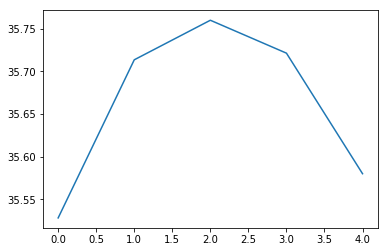

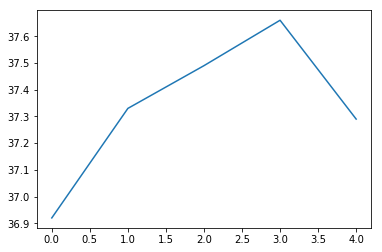

In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(out[0,:])
plt.show()


plt.figure()
plt.plot(val_label[0,:])
plt.show()

